***
# Maintaining and Updating the Evolving AstrometricSolution Retrieval System
***

<div class="alert alert-block alert-info"> This Jupyter Notebook serves as additional guideline for Chapter 7 in my Master Thesis. All code used to analyse data and produce plots is presented here 

</div>


<font color="#31688e">   <i>
This Chapter illustrates how the Evolving MasterCatalogue System handles the arrival of an astrometric $\texttt{UPDATE}$: the second data release of Gaia. At the start of this research the Gaia DR2 was not present in AstroWISE as an astrometric reference catalogue. This allows us to study how we can implement an external catalogue into our, now called, Evolving MasterCatalogue System. Next to the ingestion of the Gaia DR2 set into AstroWISE, we have to produce new $\texttt{AstrometricSolution}$s for our 12 selected SA 113 detector images. This Chapter explains how to ingest Gaia in AstroWISE, use out (new) astrometric reference catalogue to re-calibrate the images and obtain and store $\texttt{AstrometricSolution}$s in the $\texttt{MasterCatalogue}$. }    
    
</i>   </font>

<b>In Chapter 6 the initial set-up was done by dividing information obtained from an `AssociateList`, in this case `ALID = 2709001`, and storing this in three `Core Tables`. It allowed practicing how to cross-match our sources originating from different exposures stored in 12 seperate `SourceList`'s. 
The table is set up using SQLite language, using the standard Python [`sqlite3`](https://docs.python.org/3/library/sqlite3.html) module. In this notebook we have to jump to several environments through the process of ingesting an Gaia DR2 `UPDATE`. 
We start by a short explaination on how we want to `UPDATE` our Processing Pipeline. After we introduce a `UPDATE` to the System, we need the AstroWISE and AWEPIPE environment to [ingest Gaia's SA 113 patch into AstroWISE](#7.2) and use it to [recalibrate all 12 `SourceList`'s](#7.3) currently present in the system. As new `SourceList`'s have been produces, we will [ingest them and their association into the System](#7.5) using a newly produced `AssociateList`. </b>



<div class="alert alert-block alert-info">
<b>  List of content of Chapter 7</b> <br>
<i> Figure and Table numbers refer to the numbers in the thesis </i>
    <br> <br>

[7.1](#7.1) Data flow from the external Gaia Archive into AstroWISE . . . . . . . . . . . . . . . . . . . . <br>
7.1.1 Ingesting Gaia data in the AstroWISE system . . . . . . . . . . . . . . . . . . . . . . . . . . . . <br>
[7.2](#7.2)  Obtain new Astrometric Solutions using Gaia . . . . . . . . . . . . . . . . . . . . . . . . . . . . . <br>
[7.3](#7.3)  From MasterCatalogue to an Evolving MasterCatalogue system . . . . . . . . . . . . . .  <br>
[7.3.1](#7.31)  Ingesting new AstrometricSolutions into the MasterCatalogue . . . . . . . . . . . . . .  <br>
[7.3.2](#7.32)  Updating astrometry for all CelestialObjects in the MasterTable . . . . . . . . . . . . . [Figure 7.3](#figure1) <br>
[7.3.3](#7.33)  Creating (Static) Views for an Evolving MasterCatalogue . . . . . . . . . . . . . . . . . . .<br>




</div>





In [11]:
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")
%run py/setup_awe

try:
    context.set_project('OMEGACAM@VST')
    context.set_privileges(3)
    radec_SA113=[325.375,0.499]
    ra_SA113,dec_SA113,dra_SA113,ddec_SA113=radec_SA113[0],radec_SA113[1],1.,1.
    radec_SA107=[234.825,-0.263] 
    ra_SA107,dec_SA107,dra_SA107,ddec_SA107=radec_SA107[0],radec_SA107[1],1.,1.
except NameError as err:
    print("NameError: Module Context not imported, go to AW environment")
    pass


def check_system():
    try: 
        context.set_project('OMEGACAM@VST')
        context.set_privileges(3)
        return 'awe'
    except NameError as err:
        return 'local'

ImportError: Module Context not imported, go to AW environment
NameError: Module Context not imported, go to AW environment


In [12]:
import sqlite3
import pickle
import datetime
import time
import numpy as np
try: 
    import pandas as pd
    import seaborn as sns
    from scipy.stats import norm, gamma
    import scipy.stats
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()
except ImportError as err:
    print("ImportError: Python pandas module not imported, not available in Astro-WISE environment")
    import sqlite3
    pass

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cmx
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import FixedLocator, FixedFormatter

import matplotlib.dates as dates

import sys
import os

sys.path.insert(1,"py/")

from Astrom import AstromAW

import pixel2radec as p2rd
import select_from_awedb as slct
import plotutils_awe as pltut


def _to_hex(c):
    """Convert arbitray color specification to hex string.
    
    Usage: 
        color = _to_hex((0.267004, 0.004874, 0.329415)) 
    Returns:
        HEX colors in the form of #440154
    
    """
    ctype = type(c)

    # Convert rgb to hex.
    if ctype is tuple or ctype is np.ndarray or ctype is list:
        return colors.rgb2hex(c)
    if ctype is str:
        # If color is already hex, simply return it.
        regex = re.compile('^#[A-Fa-f0-9]{6}$')
        if regex.match(c):
            return c
        # Convert named color to hex.
        return colors.cnames[c]
    raise Exception("Can't handle color of type: {}".format(ctype))

# Obtaining colors for scatter plot
purple = _to_hex((0.267004, 0.004874, 0.329415))
blue_purple = _to_hex((0.267968, 0.223549, 0.512008))
blue = _to_hex((0.190631, 0.407061, 0.556089))
green_blue = _to_hex((0.128729, 0.563265, 0.551229))
green_blue2 = _to_hex((0.288921, 0.758394, 0.428426))
green = _to_hex((0.20803, 0.718701, 0.472873))
yellow_green = _to_hex((0.555484, 0.840254, 0.269281))
yellow = _to_hex((0.993248, 0.906157, 0.143936)) 

# print(purple, blue_purple, blue, green_blue, green_blue2, green, yellow_green, yellow)

# Obtaining colors for exclusion zones
silver = _to_hex((0.93, 0.93, 0.93))
grey_blue = _to_hex((0.36, 0.48, 0.58))  
hist_purple = '#7F7FFF'  # the color used for all histograms, taking into acount its alpha
cum_red = '#FD0306' #the color used for all cumulative histogram plots

#print(silver, grey_blue)

In [13]:
db_Chapter7 = "data/MasterCatalogue_Chapter7.db"

def test_query(query, db_file=db_Chapter7, p='no'):
    conn = sqlite3.connect(db_file)
    with conn:
        c = conn.cursor()
        c.execute(query)
    print("Query database for: '''{}'''".format(query))
    if p == 'yes':
        print("OUTPUT SQLITE > {}\n".format(c.fetchall()))
    else:
        print("To print OUTPUT query, set p to 'yes': test_query(query, db_file, p='yes')")
    return None

def run_query(query, output='tuple', db_file=db_Chapter7):
    conn = sqlite3.connect(db_file)
    with conn:
        c = conn.cursor()
        c.execute(query)
    # The method fetches all rows of a query result set and returns a list of tuples.
    if output == 'tuple':
        return c.fetchall()
    elif output == 'array':
        try: 
            records=c.fetchall()
            nr_q = len(records)
            nr_columns = len(records[0])
            data = [[row[i] for row in records] for i in range(nr_columns)] 
            if len(data) == 1:
                return [[row[i] for row in records] for i in range(nr_columns)][0]
            else:
                return [[row[i] for row in records] for i in range(nr_columns)]  
        except IndexError as err:
            return [row[0] for row in records]
    else:
        print("AttibuteError: run_query() only takes output = 'tuple' or 'array' as input")
    return None
    
def _get_attrlist(table_name, db_file=db_Chapter7):
    # attrlist_AID_SA_113 = _get_attrlist("AID_SA_113")
    # attrlist_ALID_SA_113 = _get_attrlist("ALID_SA_113")
    # attrlist_SLID_SA_113 = _get_attrlist("SLID_SA_113")
    query_attrlist = '''select * from pragma_table_info("{}")'''.format(table_name)
    attrlist_table = [q[1] for q in run_query(query_attrlist, db_file=DB)]
    return (attrlist_table)

def _get_slid_ids(table_name, db_file=db_Chapter7):
    # slids_ALID_SA_113_master = _get_slid_ids("ALID_SA_113")[0]
    query_slid_ids = '''select DISTINCT SLID from {}'''.format(table_name)
    aslid_ids_table = [q[0] for q in run_query(query_slid_ids, db_file=DB)]
    return (aslid_ids_table)

def _get_obs_date(table_name, db_file=db_Chapter7):
    # attrlist_te = _get_obs_date("SLID_SA_113")
    query_obs_date = '''select DISTINCT OBS_TIME from {}'''.format(table_name)
    obs_date_table = [q[0] for q in run_query(query_obs_date, db_file=DB)]
    return (obs_date_table)

def _get_unique_aid(slid, AID_table_name="AssociationTable", db_file=db_Chapter7):
    query_SLIDunique = '''SELECT DISTINCT AID_PAIR FROM {} WHERE AID_SLID1 IS {}'''.format(AID_table_name, slid)
    slids_unique = [q[0] for q in run_query(query_SLIDunique, db_file=DB)]
    return (slids_unique)

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script> <i>
The code used to load the data, plot the Figures & Tables and analyse the results is hidden by default.
To show the raw code, click  <a href="javascript:code_toggle()">here</a> </i>.''') 


<br><br>

[Go back to list of contents](#LOC)

<a id = "7.1" LOC></a>
***
# Data flow from the external Gaia Archive into AstroWISE 
***





#### Ingesting Gaia data in the AstroWISE system
<b>Introduce `UPDATE` in the AstrometricSolution Retrieval System</b>

The starting point of an `UPDATE` is the release of a new astrometric reference catalogue. In this notebook we take the Gaia DR2 as example. <br>
[This link](./thesischapter7a_AWE_IngestGaiaDR2asSourceList) will bring you to the original notebook provided by [Ewout Helmich](https://gitlab.astro-wise.org/helmich). There he demonstrated the restructuring of a .fits file obtained by [Vizier](https://vizier.u-strasbg.fr/viz-bin/VizieR). <br>In the cells below we will follow the guidelies from the notebook provided by Helmich. 

<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells below, the user needs to be in the AstroWISE environment. <br>This is why all code outputs are noted in this notebook using Markdown cells.</div>

### Rewriting a binary .fit file to LDAC catalogue .fits format

After opening the 'SA113_binary.fit file, we have to make sure that we obtain a file that contains all required columns to be used as SCAMP input. When talking about LDAC catalogues we use the definition of `keys` instead of columns. By trial and error, one can find that the required columns are `A`, `B`, `POSANG` and `FLAG`. Since where is no information for these keys, we simply import an NumPy array of either 0's or 1's having a length of the number of sources (for eevery source one element.) To be put into scamp, we make sure that the celestial coordinate keys are called `RA` and `DEC`. 

In [5]:
hdus = pyfits.open('SA113_binary.fit')

nsources = len(hdus[1].data)

A = pyfits.Column(name='A', format='F6.4', array=numpy.ones(nsources))
B = pyfits.Column(name='B', format='F6.4', array=numpy.ones(nsources))
POSANG = pyfits.Column(name='POSANG', format='D', array=numpy.zeros(nsources))
FLAG = pyfits.Column(name='FLAG', format='D', array=numpy.zeros(nsources))

columns = hdus[1].data.columns + pyfits.ColDefs([A,B,POSANG,FLAG])

columns.change_name('RA_ICRS', 'RA')
columns.change_name('DE_ICRS', 'DEC') 
columns.del_col('Dup')

ColDefs(
    name = 'RA'; format = 'D'; unit = 'deg'; disp = 'F15.11'
    name = 'e_RA_ICRS'; format = 'D'; unit = 'mas'; disp = 'F7.4'
    name = 'DEC'; format = 'D'; unit = 'deg'; disp = 'F15.11'
    name = 'e_DE_ICRS'; format = 'D'; unit = 'mas'; disp = 'F7.4'
    name = 'Source'; format = 'K'; disp = 'I19'
    name = 'Plx'; format = 'D'; unit = 'mas'; disp = 'F10.4'
    name = 'e_Plx'; format = 'E'; unit = 'mas'; disp = 'F7.4'
    name = 'pmRA'; format = 'D'; unit = 'mas/yr'; disp = 'F9.3'
    name = 'e_pmRA'; format = 'E'; unit = 'mas/yr'; disp = 'F6.3'
    name = 'pmDE'; format = 'D'; unit = 'mas/yr'; disp = 'F9.3'
    name = 'e_pmDE'; format = 'E'; unit = 'mas/yr'; disp = 'F6.3'
    name = 'FG'; format = 'E'; unit = 'e-/s'; disp = 'E11.4'
    name = 'e_FG'; format = 'E'; unit = 'e-/s'; disp = 'E11.4'
    name = 'Gmag'; format = 'D'; unit = 'mag'; disp = 'F7.4'
    name = 'e_Gmag'; format = 'D'; unit = 'mag'; disp = 'F6.4'
    name = 'FBP'; format = 'E'; unit = 'e-/s'; disp = 'E1

After changing the keys, we can print all the `pyfits.Column` to check whether the changes are applied to the binary table. 

cell output >>

``` bash
ColDefs(
    name = 'RA'; format = 'D'; unit = 'deg'; disp = 'F15.11'
    name = 'e_RA_ICRS'; format = 'D'; unit = 'mas'; disp = 'F7.4'
    name = 'DEC'; format = 'D'; unit = 'deg'; disp = 'F15.11'
    name = 'e_DE_ICRS'; format = 'D'; unit = 'mas'; disp = 'F7.4'
    name = 'Source'; format = 'K'; disp = 'I19'
    name = 'Plx'; format = 'D'; unit = 'mas'; disp = 'F10.4'
    name = 'e_Plx'; format = 'E'; unit = 'mas'; disp = 'F7.4'
    name = 'pmRA'; format = 'D'; unit = 'mas/yr'; disp = 'F9.3'
    name = 'e_pmRA'; format = 'E'; unit = 'mas/yr'; disp = 'F6.3'
    name = 'pmDE'; format = 'D'; unit = 'mas/yr'; disp = 'F9.3'
    name = 'e_pmDE'; format = 'E'; unit = 'mas/yr'; disp = 'F6.3'
    name = 'FG'; format = 'E'; unit = 'e-/s'; disp = 'E11.4'
    name = 'e_FG'; format = 'E'; unit = 'e-/s'; disp = 'E11.4'
    name = 'Gmag'; format = 'D'; unit = 'mag'; disp = 'F7.4'
    name = 'e_Gmag'; format = 'D'; unit = 'mag'; disp = 'F6.4'
    name = 'FBP'; format = 'E'; unit = 'e-/s'; disp = 'E11.4'
    name = 'e_FBP'; format = 'E'; unit = 'e-/s'; disp = 'E11.4'
    name = 'BPmag'; format = 'D'; unit = 'mag'; disp = 'F7.4'
    name = 'e_BPmag'; format = 'D'; unit = 'mag'; disp = 'F6.4'
    name = 'FRP'; format = 'E'; unit = 'e-/s'; disp = 'E11.4'
    name = 'e_FRP'; format = 'E'; unit = 'e-/s'; disp = 'E11.4'
    name = 'RPmag'; format = 'D'; unit = 'mag'; disp = 'F7.4'
    name = 'e_RPmag'; format = 'D'; unit = 'mag'; disp = 'F6.4'
    name = 'BP-RP'; format = 'D'; unit = 'mag'; disp = 'F7.4'
    name = 'RV'; format = 'D'; unit = 'km/s'; disp = 'F7.2'
    name = 'e_RV'; format = 'E'; unit = 'km/s'; disp = 'F5.2'
    name = 'Teff'; format = 'D'; unit = 'K'; disp = 'F7.2'
    name = 'AG'; format = 'E'; unit = 'mag'; disp = 'F7.4'
    name = 'E_BP-RP_'; format = 'E'; unit = 'mag'; disp = 'F7.4'
    name = 'Rad'; format = 'E'; unit = 'solRad'; disp = 'F6.2'
    name = 'Lum'; format = 'D'; unit = 'solLum'; disp = 'F9.3'
    name = 'A'; format = 'E'
    name = 'B'; format = 'E'
    name = 'POSANG'; format = 'D'
    name = 'FLAG'; format = 'D'
)
```


Now that we can see that the introduction of additional keys  worked out, we can start thinking about the LDAC structure. Like every .fits file, the first element would be a `hdulist` representing a header with information. Thereafter we create a `'OBJECTS'` table and import all information from the keys as stated above. Lastly a second table, called `'FIELDS'` will describe the additional exposure information. The following information is added:
*  `'OBJECT_POS'` as a NumPy array: [1], (representing the position of the pointing)
*  `'OBJECT_COUNT'`, as a NumPy array: [7989], (representing the number of sources present in the .fits file)
*  `'CHANNEL_NAME'`, as a NumPy array: ['OMEGACAM'], (representing the name of the instrument that observed the field, in real life, this wass not OMEGACAM, ofcourse!)
*  `'CHANNEL_NR'`, as a NumPy array: [1], (representing the position of the pointing)
*  `'MAPNAXIS'`, as a NumPy array: [2], (representing a 2D map)
*  `'DATE'`, as a NumPy array: [`time.strftime('%FT%H:%M:%S', time.gmtime(now))`], (representing the date at which the file was created)
*  `'EPOCH'`, as a NumPy array: [2000.0], (representing the observation EPOCH)

In [9]:
# ---------------------------------------------------------------------------------------
#                   Converting 'standard' .fits file to LDAC format
# ---------------------------------------------------------------------------------------

# creating hdulist
hdulist = pyfits.HDUList()

# creating the primary hdu of LDAC, should contain history and manipulation information
prhdu = pyfits.PrimaryHDU()
prhdu.header.add_history('Created from scratch')
prhdu.header.add_history('Name = %s' % 'scratch')
prhdu.header.add_history('Date = %s' % time.ctime(time.time())) # add current timestamp to header
hdulist.append(prhdu)

# first tablehdu: should be called 'OBJECTS' and contain source information
tbhdu = pyfits.BinTableHDU.from_columns(columns)
tbhdu.name = 'OBJECTS'
hdulist.append(tbhdu)

# second tablehdu: should be called 'FIELDS' and contain observation (exposure, pointing, epoch) information
fields_cols = [pyfits.Column(name='OBJECT_POS', format='1J', array=numpy.array([1])),
               pyfits.Column(name='OBJECT_COUNT', format='1J', array=numpy.array([nsources])),
               pyfits.Column(name='CHANNEL_NAME', format='16A', array=['OMEGACAM']),
               pyfits.Column(name='CHANNEL_NR', format='1J', array=numpy.array([1])),
               pyfits.Column(name='MAPNAXIS', format='1J', array=numpy.array([2])),
               pyfits.Column(name='DATE', format='32A', array=[time.strftime('%FT%H:%M:%S', time.gmtime(time.time()))]),
               pyfits.Column(name='EPOCH', format='1D', array=numpy.array([2000.0]))]
tbhdu = pyfits.BinTableHDU.from_columns(fields_cols)
tbhdu.name = 'FIELDS'
hdulist.append(tbhdu)

Using the `pyfits` module the information can be written into the `'SA113_LDAC.fits'` file and stored in the current directory. Note: We use the `pyfits` module since we can not use the `AstroPy` module within the AstroWISE environment. As `AstroPy` is based on `pyfits` both modules can do the job. 

In [10]:
filename = 'SA113_LDAC.fits'
hdulist.writeto(filename, clobber=True)

### Storing LDAC catalogue file using the `External` Class object into the AstroWISE database
The only step left is the ingestion of the LDAC catalogue into the AW database. Important is to make sure that the data is ingested into the correct project with the correct provilages:
``` python
awe> context.set_project('OMEGACAM@VST', 3)
```
We want to use the data in the 'OMEGACAM@VST' project with privilage `3`. Setting the privilage to `3` means that we can see and use the data when we are in an other project. The name that we give to the external added `SourceList` will be GAIA-DR2, as we will use the same naming convention for `REFCAT` and `ORIGIN` in our System.

In [14]:
ext = External()
ext._SOURCELIST_DATA_NAME = 'GAIA-DR2'
ext.name = 'GAIA-DR2'
ext.make_from_fits(filename)
ext.commit()
ext.store_data()

[coma-3.vm.astro.rug.nl] 2020-08-05T11:53:51 - Could not find row_identifier for fits file SA113_LDAC.fits, faking SeqNr
[coma-3.vm.astro.rug.nl] 2020-08-05T11:53:51 - Creating sourcelist_data for External 4846101 .
[coma-3.vm.astro.rug.nl] 2020-08-05T11:53:55 - Created SourceList with SLID = 76568851, name = GAIA-DR2 and 7989 sources


``` bash
[coma-3.vm.astro.rug.nl] 2020-08-05T11:53:51 - Could not find row_identifier for fits file SA113_LDAC.fits, faking SeqNr
[coma-3.vm.astro.rug.nl] 2020-08-05T11:53:51 - Creating sourcelist_data for External 4846081 .
WARNING: Different data types for  USER_0_f :  float  vs  single_float
WARNING: Different data types for  USER_64_f :  single_float  vs  float
... same warnings for: USER_75_f, USER_85_f, USER_88_f, USER_89_f, USER_38_f, USER_39_f, USER_43_f, USER_44_f, USER_51_f, USER_53_f, USER_54_f, USER_55_f
WARNING: Different data types for  SeqNr :  long  vs  int
[coma-3.vm.astro.rug.nl] 2020-08-05T11:53:55 - Created SourceList with SLID = 76568851, name = GAIA-DR2 and 7989 sources
```


Checking if the `SourceList` has been created as wanted:
``` bash
awe> (SourceList.SLID == 76568851)[0].info()

SourceList: Name of SourceList : GAIA-DR2
SourceList ID      : 76568851
Sources in list    : 7989
Parameters in list : 39

```

<br><br>
[Go back to list of contents](#LOC)
<a id = "7.2" REF></a>

***
# Obtain new Astrometric Solutions using Gaia
***

We stored our Gaia DR2 data into the AstroWISE database. Now it is time to use the data as reference catalogue to calibrate our 12 exposures. Starting from their `ReducedScienceFrame`'s, new `AstrometricParameters` are used. In this notebook you will find the original notebook as made by Gijs Verdoes Kleijn that prepared the 

<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells below, the user needs to be in the AstroWISE environment. <br>To produce `AstrometricParameters` using an externally produced `REFCAT` <br>there has to be an additional checkout from the AstroWISE code. More details follow below.  <br>This is why all code outputs are noted in this notebook using Markdown cells.</div>

### Obtaining `AstrometricParameters` obects and store them into the AstroWISE database

The name of the remote desctop used at the Kapteyn Astronomical Institute is `fabricius`. This is what we refer to as an AstroWISE environment where we store a local checkout of the AstroWISE pipeline code and are able to adjust the code as we require. The checkout used to create the data used in this poject is stored in `/net/virgo01/data/users/mulder/MP/AstroWISE` This is done by inserting the following statements in your terminal command line:

``` bash
[fabricius] home> cd /net/virgo01/data/users/mulder/MP/AstroWISE
[fabricius] AstroWISE> git clone https://gitlab.astro-wise.org/omegacen/astro.git
[fabricius] AstroWISE> git clone https://gitlab.astro-wise.org/omegacen/common.git
[fabricius] AstroWISE> git checkout gvk/astromety-review
[fabricius] AstroWISE> setenv AWEPIPE /net/virgo01/data/users/mulder/MP/AstroWISE

[fabricius] AstroWISE> module add awe
[fabricius] AstroWISE> jawe notebook
```

The code below should be imported into a notebook, to run the pipeline creating new `AstrometricParameters` using our Gaia `SourceList` as REFCAT.

In [17]:
SLIDexposures = [76154181,76154971,76154981,76154991,76155001,76155011,76155021,76155031,76155041,76155051,76155061, 76155071]

import astro.config.startup
from common.database.Context import context
context.set_project('OMEGACAM@VST', 3)

results = []
for slid in SLIDexposures:
    redsframe =(SourceList.SLID==slid)[0].frame
    AP = AstrometricParameters()
    AP.set_config(scamp=True)

    #Set instrument specific default config properties
    from astro.instrument.ConfigUpdaterFactory import create_config_updater
    instrument = redsframe.instrument.name
    filter = redsframe.filter.name
    chip = redsframe.chip.name
    config_updater = create_config_updater(instrument)
    config_updater.update(AP, filter=filter, chip=chip)

    AP.reduced = redsframe
    AP.reduced.retrieve()
    AP.reduced.weight.retrieve()
    AP.process_params.REFCAT_SLID=76568851
    AP.process_params.REFCAT='GAIA-DR2'
    
    AP.make_with_scamp()
    AP.verify()
    AP.commit()
    results.append( (slid, AP.object_id) )
    
    # Inspect figures MUST be made after the ProcessTarget
    # is committed and an object_id assigned to it.
    AP.make_inspect_figures()
    for fig in AP.figures:
        fig.store()
        fig.commit()
        
for result in results:
    print(result[0], result[1] ,AstrometricParameters(object_id=result[1]).creation_date)

[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:24 - Retrieving Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4509118-d4b707aaab715eea0e4f31d755a17cae52ea6fe6.fits
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:26 - Retrieved Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4509118-d4b707aaab715eea0e4f31d755a17cae52ea6fe6.fits[32807kB] in 1.84 seconds (17801.09kBps)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:26 - Retrieving Cal-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Wei-58969.4510008-fbcbd5399c7f92c57b7e7e0286dfb6da63e64373.fits.gz
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:30 - Retrieved Cal-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Wei-58969.4510008-fbcbd5399c7f92c57b7e7e0286dfb6da63e64373.fits.gz[24192kB] in 3.86 seconds (6270.36kBps)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:30 - Not keeping Cal-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Wei-58969.4510008-fbcbd5399c7f92c57b7e7e0286dfb6da63e64373.fits.gz
[coma-3.vm.astro.r

[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:37 - The seeing (FWHM) is   0.95 arcsec
Found 208 associates out of 8203 sources from 2 catalogs in 0.15 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:38 - Clipping 4 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:38 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:38 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:38 - Clipping 5 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:38 - Clipping 1 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:38 - Clipping 1 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:38 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:38 - Clipping 1 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:38 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:38 - Clipping 1 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:38 - Clipped a total of 22 out of 208 point(s)
[coma-3.vm.

[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:55 - The seeing (FWHM) is   1.12 arcsec
Found 178 associates out of 8169 sources from 2 catalogs in 0.14 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:56 - Clipping 5 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:56 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:56 - Clipping 1 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:56 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:56 - Clipped a total of 10 out of 178 point(s)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:56 - SETTING MEAN_DRA  to 0.0839073788508
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:56 - SETTING MEAN_DDEC to 0.0220512001537
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:56 - SETTING SIG_DRA   to 0.0755883947211
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:56 - SETTING SIG_DDEC  to 0.0516855192444
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:56 - SETTING NREF      to 168
[coma-3.vm.astro.rug.nl] 2020-08-05T12:03:56 - 

[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - The seeing (FWHM) is   1.55 arcsec
Found 148 associates out of 8135 sources from 2 catalogs in 0.12 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - Clipping 4 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - Clipping 4 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - Clipping 4 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - Clipping 4 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - Clipped a total of 16 out of 148 point(s)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - SETTING MEAN_DRA  to 0.0414487502613
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - SETTING MEAN_DDEC to 0.0244673430559
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - SETTING SIG_DRA   to 0.0758171685138
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - SETTING SIG_DDEC  to 0.036464551077
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - SETTING NREF      to 132
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:12 - S

[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 - The seeing (FWHM) is   0.93 arcsec
Found 194 associates out of 8189 sources from 2 catalogs in 0.14 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 - Clipping 5 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 - Clipping 6 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 - Clipping 1 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 - Clipped a total of 18 out of 194 point(s)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 - SETTING MEAN_DRA  to -0.0244557456685
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 - SETTING MEAN_DDEC to 0.0222458620867
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 - SETTING SIG_DRA   to 0.0593089718167
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 - SETTING SIG_DDEC  to 0.033893948493
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:25 

[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:43 - The seeing (FWHM) is   1.03 arcsec
Found 134 associates out of 8120 sources from 2 catalogs in 0.13 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:44 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:44 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:44 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:44 - Clipping 1 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:44 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:44 - Clipped a total of 12 out of 134 point(s)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:44 - SETTING MEAN_DRA  to 0.0673500648742
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:44 - SETTING MEAN_DDEC to 0.0265229743117
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:44 - SETTING SIG_DRA   to 0.0876701687242
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:44 - SETTING SIG_DDEC  to 0.0365224646504
[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:44 

[coma-3.vm.astro.rug.nl] 2020-08-05T12:04:59 - The seeing (FWHM) is   0.98 arcsec
Found 193 associates out of 8181 sources from 2 catalogs in 0.15 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:00 - Clipping 5 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:00 - Clipping 4 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:00 - Clipping 4 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:00 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:00 - Clipped a total of 16 out of 193 point(s)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:00 - SETTING MEAN_DRA  to 0.0288198850175
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:00 - SETTING MEAN_DDEC to 0.0231528048749
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:00 - SETTING SIG_DRA   to 0.0595474438923
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:00 - SETTING SIG_DDEC  to 0.0397229798025
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:00 - SETTING NREF      to 177
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:00 - 

[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - The seeing (FWHM) is   0.97 arcsec
Found 206 associates out of 8191 sources from 2 catalogs in 0.13 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - Clipping 5 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - Clipping 1 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - Clipped a total of 19 out of 206 point(s)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - SETTING MEAN_DRA  to 0.0193109005172
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - SETTING MEAN_DDEC to 0.0247006105023
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:17 - SETTING SIG_DRA   

[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - The seeing (FWHM) is   0.80 arcsec
Found 216 associates out of 8204 sources from 2 catalogs in 0.14 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - Clipping 4 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - Clipped a total of 12 out of 216 point(s)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - SETTING MEAN_DRA  to 0.039331487955
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - SETTING MEAN_DDEC to 0.017712824025
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - SETTING SIG_DRA   to 0.0524891355432
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - SETTING SIG_DDEC  to 0.0315158703741
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - SETTING NREF      to 204
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:36 - SE

[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - The seeing (FWHM) is   0.74 arcsec
Found 211 associates out of 8198 sources from 2 catalogs in 0.14 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - Clipping 4 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - Clipping 5 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - Clipped a total of 13 out of 211 point(s)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - SETTING MEAN_DRA  to 0.01428665754
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - SETTING MEAN_DDEC to 0.0167746893893
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - SETTING SIG_DRA   to 0.0488683060531
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - SETTING SIG_DDEC  to 0.029668788782
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - SETTING NREF      to 198
[coma-3.vm.astro.rug.nl] 2020-08-05T12:05:57 - SET

[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:18 - The seeing (FWHM) is   1.08 arcsec
Found 188 associates out of 8172 sources from 2 catalogs in 0.14 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:19 - Clipping 5 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:19 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:19 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:19 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:19 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:19 - Clipping 1 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:19 - Clipped a total of 17 out of 188 point(s)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:19 - SETTING MEAN_DRA  to 0.0342536462443
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:19 - SETTING MEAN_DDEC to 0.0248711867284
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:19 - SETTING SIG_DRA   to 0.0569587675276
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:19 - SETTING 

[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:32 - The seeing (FWHM) is   0.87 arcsec
Found 199 associates out of 8190 sources from 2 catalogs in 0.14 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:33 - Clipping 5 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:33 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:33 - Clipping 5 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:33 - Clipping 3 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:33 - Clipped a total of 16 out of 199 point(s)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:33 - SETTING MEAN_DRA  to 0.0269663918135
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:33 - SETTING MEAN_DDEC to 0.0170095840985
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:33 - SETTING SIG_DRA   to 0.0631950120417
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:33 - SETTING SIG_DDEC  to 0.0334432082937
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:33 - SETTING NREF      to 183
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:33 - 

[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - The seeing (FWHM) is   0.80 arcsec
Found 213 associates out of 8201 sources from 2 catalogs in 0.12 seconds     
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - Clipping 4 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - Clipping 2 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - Clipping 4 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - Clipping 1 point(s) . . . 
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - Clipped a total of 11 out of 213 point(s)
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - SETTING MEAN_DRA  to 0.0488185277207
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - SETTING MEAN_DDEC to 0.0186840280166
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - SETTING SIG_DRA   to 0.0486522023893
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - SETTING SIG_DDEC  to 0.0320159481011
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - SETTING NREF      to 202
[coma-3.vm.astro.rug.nl] 2020-08-05T12:06:53 - 

``` bash
76154181 'AAA5628049796AAEE053174A17AC3576' 2020-08-05 10:03:38.164544
76154971 'AAA5628049816AAEE053174A17AC3576' 2020-08-05 10:03:56.073703
76154981 'AAA5628049896AAEE053174A17AC3576' 2020-08-05 10:04:12.514145
76154991 'AAA5628049916AAEE053174A17AC3576' 2020-08-05 10:04:25.546471
76155001 'AAA5628049996AAEE053174A17AC3576' 2020-08-05 10:04:44.266449
76155011 'AAA5628049A16AAEE053174A17AC3576' 2020-08-05 10:05:00.146821
76155021 'AAA5628049A86AAEE053174A17AC3576' 2020-08-05 10:05:17.519388
76155031 'AAA5628049B06AAEE053174A17AC3576' 2020-08-05 10:05:36.763881
76155041 'AAA5628049B86AAEE053174A17AC3576' 2020-08-05 10:05:57.763302
76155051 'AAA5204AFCB152F3E053174A17AC5E3F' 2020-08-05 10:06:19.047537
76155061 'AAA5628049C06AAEE053174A17AC3576' 2020-08-05 10:06:33.257599
76155071 'AAA5204AFCB952F3E053174A17AC5E3F' 2020-08-05 10:06:53.356802

```

### Producing and Storing `SourceList` Objects by using just ingested `AstrometricParameters`

Producing `SourceList` does not require the local checkout of the AstroWISE code, however it does require the use of a jawe notebook. 

<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells below, the user needs to be in the AstroWISE environment. <br>This is why all code outputs are noted in this notebook using Markdown cells.</div>



In [20]:
for slid in SLIDexposures:
    redsframe = (SourceList.SLID == slid)[0].frame
    redsfile = (SourceList.SLID == slid)[0].frame.filename
    creationdate = (AstrometricParameters.reduced == redsframe).order_by('creation_date')[-1]

    query = (ReducedScienceFrame.filename == redsfile)
    frame = query[0]
    AP = (AstrometricParameters.reduced == frame).max('creation_date')
    print(AP.process_params.REFCAT)
    print('-----------------------')
    frame.retrieve()
    frame.weight.retrieve()
    sourcelist = SourceList()
    sourcelist.frame = frame
    sourcelist.sexparam = ['MAG_APER', 'MAGERR_APER', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_APER', 'FLUXERR_APER', 'ERRX2_IMAGE', 'ERRY2_IMAGE', 'ERRXY_IMAGE', 'XWIN', 'YWIN', 'ERRX2WIN', 'ERRY2WIN', 'ERRXYWIN', 'AWIN', 'BWIN', 'ERRAWIN', 'ERRBWIN', 'ERRTHETAWIN', 'THETAWIN', 'X2WIN', 'Y2WIN', 'XYWIN', 'CXXWIN', 'CYYWIN', 'CXYWIN', 'ERRCXXWIN', 'ERRCYYWIN', 'ERRCXYWIN']
    sourcelist.astrom_params = AP
    sourcelist.make()
    sourcelist.commit()

GAIA-DR2
-----------------------
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:32 - Retrieving Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4509118-d4b707aaab715eea0e4f31d755a17cae52ea6fe6.fits
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:32 - Retrieved Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4509118-d4b707aaab715eea0e4f31d755a17cae52ea6fe6.fits
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:32 - Saving tmp1596622172.769600.88dde03f-c7cc-41b9-a9a8-839a375b68fd-realframe-Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4509118-d4b707aaab715eea0e4f31d755a17cae52ea6fe6.fits
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:33 - Using SExtractor version 2.8.6
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:33 - Running: sex tmp1596622172.769600.88dde03f-c7cc-41b9-a9a8-839a375b68fd-realframe-Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4509118-d4b707aaab715eea0e4f31d755a17cae52ea6fe6.fits -c tmp1596622172.768925.31b5945e-6aed-4c

[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:50 - Outer bounding box: (325.22145,  0.76130,325.10028,  0.76110,325.10001,  1.00359,325.22110,  1.00381 )
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:53 - Created SourceList with SLID = 76568891, name = SL-WMULDER-0076568891 and 308 sources
GAIA-DR2
-----------------------
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:53 - Retrieving Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4844704-85f3df9694c81cdbb2ce2aa79835a8841c75ba8d.fits
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:53 - Retrieved Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4844704-85f3df9694c81cdbb2ce2aa79835a8841c75ba8d.fits
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:53 - Saving tmp1596622193.828526.52e87c43-0e5d-4e26-98dc-56b3c61f26ef-realframe-Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4844704-85f3df9694c81cdbb2ce2aa79835a8841c75ba8d.fits
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:54 - Using SExtractor version 2.8.6
[coma-

[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:10 - RUNNING: ldacconv -i tmp1596622209.111111.d9b8089b-8954-44ea-a185-75fe9363ae73.sex.cat -o SL-catalog.tmp1596622209.111111.d9b8089b-8954-44ea-a185-75fe9363ae73.cat -b 1 -c OMEGACAM -f "SloanR"
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:10 - RUNNING: ldacrenkey -i SL-catalog.tmp1596622209.111111.d9b8089b-8954-44ea-a185-75fe9363ae73.cat -o renkey.dat -t OBJECTS -k Theta POSANG
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:10 - RUNNING: ldacrenkey -i SL-catalog.tmp1596622209.111111.d9b8089b-8954-44ea-a185-75fe9363ae73.cat -o renkey.dat -t OBJECTS -k ALPHA_SKY RA
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:10 - RUNNING: ldacrenkey -i SL-catalog.tmp1596622209.111111.d9b8089b-8954-44ea-a185-75fe9363ae73.cat -o renkey.dat -t OBJECTS -k DELTA_SKY DEC
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:11 - Outer bounding box: (325.22005,  0.75518,325.09914,  0.75494,325.09873,  0.99719,325.21960,  0.99742 )
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:14 - Created Sou

[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:30 - Using SExtractor version 2.8.6
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:30 - Running: sex tmp1596622230.024164.4519a950-2c3c-49f3-9c44-8f014aea2224-realframe-Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.6106413-ebcfe48156cdb23909d31fb9df7d26a814f9965b.fits -c tmp1596622230.023649.d78efc0e-5a5f-494f-8f4e-7a28a3fb2431.SExtractor.conf
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:31 - RUNNING: ldacconv -i tmp1596622230.024164.4519a950-2c3c-49f3-9c44-8f014aea2224.sex.cat -o SL-catalog.tmp1596622230.024164.4519a950-2c3c-49f3-9c44-8f014aea2224.cat -b 1 -c OMEGACAM -f "SloanR"
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:31 - RUNNING: ldacrenkey -i SL-catalog.tmp1596622230.024164.4519a950-2c3c-49f3-9c44-8f014aea2224.cat -o renkey.dat -t OBJECTS -k Theta POSANG
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:31 - RUNNING: ldacrenkey -i SL-catalog.tmp1596622230.024164.4519a950-2c3c-49f3-9c44-8f014aea2224.cat -o renkey.dat -t OBJECTS -k AL

```
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:38 - Created SourceList with SLID = 76568861, name = SL-WMULDER-0076568861 and 311 sources
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:43 - Created SourceList with SLID = 76568871, name = SL-WMULDER-0076568871 and 282 sources
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:48 - Created SourceList with SLID = 76568881, name = SL-WMULDER-0076568881 and 215 sources
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:53 - Created SourceList with SLID = 76568891, name = SL-WMULDER-0076568891 and 308 sources
[coma-3.vm.astro.rug.nl] 2020-08-05T12:09:58 - Created SourceList with SLID = 76568901, name = SL-WMULDER-0076568901 and 183 sources
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:03 - Created SourceList with SLID = 76568911, name = SL-WMULDER-0076568911 and 288 sources
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:08 - Created SourceList with SLID = 76568921, name = SL-WMULDER-0076568921 and 297 sources
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:14 - Created SourceList with SLID = 76568931, name = SL-WMULDER-0076568931 and 310 sources
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:19 - Created SourceList with SLID = 76568941, name = SL-WMULDER-0076568941 and 298 sources
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:24 - Created SourceList with SLID = 76568951, name = SL-WMULDER-0076568951 and 278 sources
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:29 - Created SourceList with SLID = 76568961, name = SL-WMULDER-0076568961 and 303 sources
[coma-3.vm.astro.rug.nl] 2020-08-05T12:10:35 - Created SourceList with SLID = 76568971, name = SL-WMULDER-0076568971 and 307 sources
```

Now we want to select the new `SLID`s directly from the AstroWISE database. This can be done by selecting [per `ReducedScienceFrame`] all the `SourceList`s that have been produced with that specific ReducedScienceFrame. Querying for the most current `SourceList` will give us the object for which we can obtain the `SLID`.
``` python
SLIDexposures = [76154181,76154971,76154981,76154991,76155001,76155011,76155021,76155031,76155041,76155051,76155061, 76155071]
SLIDexposures_gaia = [] 

for slid in SLIDexposures:
    redsframe = (SourceList.SLID == slid)[0].frame
    sourcelist = (SourceList.frame == redsframe).order_by('creation_date')[-1]
    slid_gaia = sourcelist.SLID
    SLIDexposures_gaia.append(slid_gaia)
```


In [29]:
SLIDexposures = [76154181,76154971,76154981,76154991,76155001,76155011,76155021,76155031,76155041,76155051,76155061, 76155071]
SLIDexposures_gaia = [] 

for slid in SLIDexposures:
    redsframe = (SourceList.SLID == slid)[0].frame
    sourcelist = (SourceList.frame == redsframe).order_by('creation_date')[-1]
    slid_gaia = sourcelist.SLID
    SLIDexposures_gaia.append(slid_gaia)
run = 'yes'

referencelist = (SourceList.SLID == 76568851)[0]  # Newly created Gaia SL
usnosourcelist = (SourceList.SLID == 565361)[0]  # USNO SLID already in database
sourcelists = [(SourceList.SLID == slid)[0] for slid in SLIDexposures_gaia]

nr_sourcelists = len(sourcelists)

if run == 'yes':
    import datetime
    today = datetime.date.today().strftime("%y%m%d")
    AL0_name = 'MasterTableGAIAMASTER{}_{}_0_type3'.format(nr_sourcelists, today)
    print("Name AssociateList: {}".format(AL0_name))

    AL0 = AssociateList()
    AL0.input_lists.append(referencelist)
    AL0.input_lists.append(usnosourcelist)
    AL0.input_lists.append(sourcelists[0])
    AL0.input_lists.append(sourcelists[1])
    AL0.input_lists.append(sourcelists[2])
    AL0.input_lists.append(sourcelists[3])
    AL0.input_lists.append(sourcelists[4])
    AL0.input_lists.append(sourcelists[5])
    AL0.input_lists.append(sourcelists[6])
    AL0.input_lists.append(sourcelists[7])
    AL0.input_lists.append(sourcelists[8])
    AL0.input_lists.append(sourcelists[9])
    AL0.input_lists.append(sourcelists[10])
    AL0.input_lists.append(sourcelists[11])
    AL0.set_search_distance(5.0)
    AL0.associatelisttype = 3
    AL0.process_params.SEXTRACTOR_FLAG_MASK = 255
    AL0.name = AL0_name
    AL0.make()
    AL0.commit()
    
# SLIDexposures_gaia = [76568861, 76568871, 76568881, 76568891, 76568901, 76568911, 76568921, 76568931, 76568941, 76568951, 76568961, 76568971]
#  Created ALID  2709561, name = "MasterTableGAIAMASTER12_200805_0_type3" and 331 associates!

Name AssociateList: MasterTableGAIAMASTER12_200805_0_type3
[coma-3.vm.astro.rug.nl] 2020-08-05T12:43:32 - Outer bounding box: (325.87498, -0.00072,324.87517, -0.00072,324.87517,  1.00364,325.87498,  1.00385 )
[coma-3.vm.astro.rug.nl] 2020-08-05T12:43:57 - Copied 33068 sources to scratch table
[coma-3.vm.astro.rug.nl] 2020-08-05T12:44:13 - Pairing query found 31139 pairs
[coma-3.vm.astro.rug.nl] 2020-08-05T12:44:13 - Looking for closest pairs
[coma-3.vm.astro.rug.nl] 2020-08-05T12:44:13 - After filtering 29209 pairs remain
[coma-3.vm.astro.rug.nl] 2020-08-05T12:44:24 - Needed 5 loops to combine 29209 pairs into 7015 associations
[coma-3.vm.astro.rug.nl] 2020-08-05T12:44:31 - Created Matched AssociateList with ALID = 2709571, name = "MasterTableGAIAMASTER12_200805_0_type3" and 7015 associates!


``` bash
Name AssociateList: MasterTableGAIAMASTER12_200805_0_type3
[coma-3.vm.astro.rug.nl] 2020-08-05T12:15:23 - Outer bounding box: (325.22209,  0.75397,325.09896,  0.75397,325.09897,  1.00359,325.22211,  1.00359 )
[coma-3.vm.astro.rug.nl] 2020-08-05T12:15:45 - Copied 4185 sources to scratch table
[coma-3.vm.astro.rug.nl] 2020-08-05T12:15:50 - Pairing query found 20417 pairs
[coma-3.vm.astro.rug.nl] 2020-08-05T12:15:50 - Looking for closest pairs
[coma-3.vm.astro.rug.nl] 2020-08-05T12:15:50 - After filtering 19424 pairs remain
[coma-3.vm.astro.rug.nl] 2020-08-05T12:15:58 - Needed 5 loops to combine 19424 pairs into 331 associations
[coma-3.vm.astro.rug.nl] 2020-08-05T12:16:03 - Created Matched AssociateList with ALID = 2709561, name = "MasterTableGAIAMASTER12_200805_0_type3" and 331 associates!
```
``` bash
Name AssociateList: MasterTableGAIAMASTER12_200805_0_type3
[coma-3.vm.astro.rug.nl] 2020-08-05T12:43:32 - Outer bounding box: (325.87498, -0.00072,324.87517, -0.00072,324.87517,  1.00364,325.87498,  1.00385 )
[coma-3.vm.astro.rug.nl] 2020-08-05T12:43:57 - Copied 33068 sources to scratch table
[coma-3.vm.astro.rug.nl] 2020-08-05T12:44:13 - Pairing query found 31139 pairs
[coma-3.vm.astro.rug.nl] 2020-08-05T12:44:13 - Looking for closest pairs
[coma-3.vm.astro.rug.nl] 2020-08-05T12:44:13 - After filtering 29209 pairs remain
[coma-3.vm.astro.rug.nl] 2020-08-05T12:44:24 - Needed 5 loops to combine 29209 pairs into 7015 associations
[coma-3.vm.astro.rug.nl] 2020-08-05T12:44:31 - Created Matched AssociateList with ALID = 2709571, name = "MasterTableGAIAMASTER12_200805_0_type3" and 7015 associates!
```

<br><br>
[Go back to list of contents](#LOC)
<a id = "7.3" REF></a>

***
# From MasterCatalogue to an Evolving MasterCatalogue system
***
We obtained the astrometrical solutions for the 12 exposures. They are stored in the `SourceList`'s connected to `AssociateList.ALID == `. This `AssociateList` is created using the `.associatelisttype` parameter set to .... . Therefore the associations are preformed using ... association. The last step would be the ingestion of the solutions into our MasterCatalogue.

This can be done in two ways:
1. Ingestion of solutions from the `AssociateList` object into seperate `Core Tables`_gaia and importing using SQL statements.
*  Ingestion of solutions direcly from the `AssociateList` object into the `MasterTable` and `Core Tables`.

### Ingestion of solutions from the `AssociateList` object into seperate `Core Tables`_gaia and importing using SQL statements.

We can use the same functions that we used to set-up the initial `MasterCatalogue`: `generate_ALIDtable()`, `generate_SLIDtable()`, `generate_AIDtable()`, `generate_MASTERtable()`. Recall: the initial catalogue only contains instrumental and USNO-B1.0 calibrated astrometrical solutions. <br><br>

Advantages of this method is that 
* the original code can be re-used
* only a small adjustment has to be made to import information originating from the Gaia `SourceList` (as was done for the USNO-B1.0 SourceList as well)

Disadvantages:
* check has to be added whether different `AssociateList` objects produce different `AID`'s (we know this answer is YES, but we will still verify this)
* each time there is an `UPDATE`, you have to adjust the maincode, since a reference catalogue `SourceList` had an other data structure.

<a id = "MC" MasterCatalogue></a>
***
### Creating MasterCatalogue
***

Creating a MasterCatalogue like in the Notebook of Chapter 6. The System is identical, only this one will be updated.

In [14]:
class MasterCatalogue():
    def __init__(self, db_file="data/", name='MasterCatalogue', name_add=''):
        if check_system() == 'awe':
            pass
        else: 
            print("MasterCatalogue() can not be used in Anaconda environment. Go to AW environment to continue")
            return None
        
        self.name = name
        if db_file == "data/":
            self.db_file = db_file+name+name_add+'.db'
        else:
            self.db_file = db_file
        self.name_add = name_add
        
    def generate(self, alid=2709001):
        generate_ALIDtable(alid= alid, name= 'SourceExtractionTable{}'.format(self.name_add), db_file=self.db_file)
        generate_SLIDtable(alid= alid, name= 'AstromSolutionTable{}'.format(self.name_add), db_file=self.db_file)
        generate_AIDtable(alid= alid, name= 'AssociationTable{}'.format(self.name_add), db_file=self.db_file)
        return "{} succesfully generated, ready to create MasterTable()".format(self.name)

    
    def UPDATE(self, slid=76568851, RefCat='GAIA-DR2'):
        # From the AWE SCAMP pipeline we obtain the values for SLID and the respecively AstrometricParameters as calibrated to GAIA
        SLID2AP = (76154181,  AstrometricParameters(object_id='AAA5628049796AAEE053174A17AC3576') ), (76154971,  AstrometricParameters(object_id='AAA5628049816AAEE053174A17AC3576') ), (76154981,  AstrometricParameters(object_id='AAA5628049896AAEE053174A17AC3576') ), (76154991,  AstrometricParameters(object_id='AAA5628049916AAEE053174A17AC3576') ),(76155001,  AstrometricParameters(object_id='AAA5628049996AAEE053174A17AC3576') ), (76155011,  AstrometricParameters(object_id='AAA5628049A16AAEE053174A17AC3576') ), (76155021,  AstrometricParameters(object_id='AAA5628049A86AAEE053174A17AC3576') ), (76155031,  AstrometricParameters(object_id='AAA5628049B06AAEE053174A17AC3576') ), (76155041,  AstrometricParameters(object_id='AAA5628049B86AAEE053174A17AC3576') ), (76155051,  AstrometricParameters(object_id='AAA5204AFCB152F3E053174A17AC5E3F') ), (76155061,  AstrometricParameters(object_id='AAA5628049C06AAEE053174A17AC3576') ), (76155071,  AstrometricParameters(object_id='AAA5204AFCB952F3E053174A17AC5E3F') ) 

        conn = sqlite3.connect(self.db_file)
        c = conn.cursor()
        print("Connected to database...")
        
        table_name = 'AstromSolutionTable{}'.format(self.name_add)  # name of the table to be created
        column_instrument = 'INSTRUMENT'; column_detimage = 'DI_ID'; column_det_id = 'D_ID'; column_origin = 'ORIGIN'; column_timeobs = 'TIME_OBS'; column_cd11 = 'CD1_1'; column_cd12 = 'CD1_2'; column_cd21 = 'CD2_1'; column_cd22 = 'CD2_2' # name of the first, second, third and fourth (ect.) column to be created
        column_crpix1 = 'CRPIX1'; column_crval1 = 'CRVAL1'; column_ctype1 = 'CTYPE1'; column_crpix2 = 'CRPIX2'; column_crval2 = 'CRVAL2'; column_ctype2 = 'CTYPE2' #ect.
        column_p1_0 = 'PV1_0'; column_p1_1 = 'PV1_1'; column_p1_2 = 'PV1_2'; column_p1_3 = 'PV1_3'; column_p1_4 = 'PV1_4'; 
        column_p1_5 = 'PV1_5'; column_p1_6 = 'PV1_6'; column_p1_7 = 'PV1_7'; column_p1_8 = 'PV1_8'; column_p1_9 = 'PV1_9'; 
        column_p1_10 = 'PV1_10'
        column_p2_0 = 'PV2_0'; column_p2_1 = 'PV2_1'; column_p2_2 = 'PV2_2'; column_p2_3 = 'PV2_3'; column_p2_4 = 'PV2_4'; 
        column_p2_5 = 'PV2_5'; column_p2_6 = 'PV2_6'; column_p2_7 = 'PV2_7'; column_p2_8 = 'PV2_8'; column_p2_9 = 'PV2_9'; 
        column_p2_10 = 'PV2_10'
        column_airmass = 'AIRMASS'; column_az = "ALT_AZ"; column_refcat = 'REFCAT'; column_nref = 'NREF'; column_rms = 'RMS' #ect.
        column_mdra = 'MEAN_DRA'; column_sdra = 'SIG_DRA'; column_mddec = 'MEAN_DDEC'; column_sddec = 'SIG_DDEC' #ect.

        for detector_image in SLID2AP:
            v_detimage = detector_image[0] ; APobjectID = detector_image[1]
            AP = APobjectID
            RS = AP.reduced
            v_det_id = AP.chip.name
            v_instrument = AP.instrument.name
            v_timeobs = RS.DATE_OBS; v_cd11 = AP.CD1_1; v_cd12 = AP.CD1_2; v_cd21 = AP.CD2_1; v_cd22 = AP.CD2_2
            v_crpix1 = AP.CRPIX1; v_crval1 = AP.CRVAL1; v_ctype1 = str(AP.CTYPE1); v_crpix2 = AP.CRPIX2; v_crval2 = AP.CRVAL2; v_ctype2 = AP.CTYPE2
            v_p1_0=AP.PV1_0; v_p1_1=AP.PV1_1; v_p1_2=AP.PV1_2; v_p1_3=AP.PV1_3; v_p1_4=AP.PV1_4; 
            v_p1_5=AP.PV1_5; v_p1_6=AP.PV1_6; v_p1_7=AP.PV1_7; v_p1_8=AP.PV1_8; v_p1_9=AP.PV1_9; 
            v_p1_10=AP.PV1_10;
            v_p2_0=AP.PV2_0; v_p2_1=AP.PV2_1; v_p2_2=AP.PV2_2; v_p2_3=AP.PV2_3; v_p2_4=AP.PV2_4; 
            v_p2_5=AP.PV2_5; v_p2_6=AP.PV2_6; v_p2_7=AP.PV2_7; v_p2_8=AP.PV2_8; v_p2_9=AP.PV2_9; 
            v_p2_10=AP.PV2_10;
            v_airmass = np.mean([RS.AIRMEND,RS.AIRMSTRT]); v_az = "ALT_AZ"; v_refcat = AP.process_params.REFCAT; v_origin = 'OmegaCAM SA_113'
            v_nref = AP.NREF; v_rms = AP.RMS
            v_mdra = AP.MEAN_DRA; v_sdra = AP.SIG_DRA; v_mddec = AP.MEAN_DDEC; v_sddec = AP.SIG_DDEC
            
            c.execute('''INSERT OR IGNORE INTO {a_tn} ({a_instrument}, {a_detimage}, {a_det_id}, {a_origin}, {a_timeobs}, {a_cd11}, {a_cd12}, {a_cd21}, {a_cd22}, {a_crpix1}, {a_crval1}, {a_ctype1}, 
                                {a_crpix2}, {a_crval2}, {a_ctype2}, 
                                {ap1_0}, {ap1_1},  {ap1_2},  {ap1_3},  {ap1_4}, {ap1_5}, {ap1_6},  {ap1_7},  {ap1_8},  {ap1_9}, {ap1_10},
                                {ap2_0}, {ap2_1},  {ap2_2},  {ap2_3},  {ap2_4}, {ap2_5}, {ap2_6},  {ap2_7},  {ap2_8},  {ap2_9}, {ap2_10}, 
                                {a_airmass}, {a_az}, {a_refcat}, {a_nref}, {a_rms}, {a_mdra}, {a_sdra}, {a_mddec}, 
                                {a_sddec}) VALUES ('{vi}', {vexp}, '{v0}', '{vo}', DATETIME('{v1}'), {v2}, {v3}, {v4}, {v5}, {v6}, {v7}, '{v8}', {v9}, {v10}, '{v11}',
                                {v_1_0}, {v_1_1},  {v_1_2},  {v_1_3},  {v_1_4}, {v_1_5}, {v_1_6},  {v_1_7},  {v_1_8},  {v_1_9}, {v_1_10},
                                {v_2_0}, {v_2_1},  {v_2_2},  {v_2_3},  {v_2_4}, {v_2_5}, {v_2_6},  {v_2_7},  {v_2_8},  {v_2_9}, {v_2_10}, {v12}, 'ALT-AZ', '{v14}', {v15},
                                {v16}, {v17}, {v18}, {v19}, {v20})'''. \
                      format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_origin=column_origin, a_timeobs= column_timeobs, a_cd11=column_cd11 , a_cd12= column_cd12, a_cd21= column_cd21, 
                             a_cd22= column_cd22, a_crpix1= column_crpix1, a_crval1= column_crval1, a_ctype1= column_ctype1, a_crpix2= column_crpix2, 
                             a_crval2= column_crval2, a_ctype2= column_ctype2, 
                             ap1_0=column_p1_0, ap1_1=column_p1_1, ap1_2=column_p1_2, ap1_3=column_p1_3, ap1_4=column_p1_4, 
                             ap1_5=column_p1_5, ap1_6=column_p1_6, ap1_7=column_p1_7, ap1_8=column_p1_8, ap1_9=column_p1_9, 
                             ap1_10=column_p1_10,
                             ap2_0=column_p2_0, ap2_1=column_p2_1, ap2_2=column_p2_2, ap2_3=column_p2_3, ap2_4=column_p2_4, 
                             ap2_5=column_p2_5, ap2_6=column_p2_6, ap2_7=column_p2_7, ap2_8=column_p2_8, ap2_9=column_p2_9, 
                             ap2_10=column_p2_10,
                             a_airmass= column_airmass, a_az= column_az, a_refcat= column_refcat, 
                             a_nref= column_nref, a_rms= column_rms, a_mdra= column_mdra, a_sdra= column_sdra, a_mddec= column_mddec, a_sddec= column_sddec, 
                             vi =v_instrument, vexp=v_detimage, v0=v_det_id, vo=v_origin, v1=v_timeobs, v2=v_cd11, v3=v_cd12, v4=v_cd21, v5=v_cd22, v6=v_crpix1, v7=v_crval1, v8=v_ctype1, v9=v_crpix2, 
                             v10=v_crval2, v11=v_ctype2, 
                             v_1_0=v_p1_0, v_1_1=v_p1_1, v_1_2=v_p1_2, v_1_3=v_p1_3, v_1_4=v_p1_4, 
                             v_1_5=v_p1_5, v_1_6=v_p1_6, v_1_7=v_p1_7, v_1_8=v_p1_8, v_1_9=v_p1_9, 
                             v_1_10=v_p1_10,
                             v_2_0=v_p2_0, v_2_1=v_p2_1, v_2_2=v_p2_2, v_2_3=v_p2_3, v_2_4=v_p2_4, 
                             v_2_5=v_p2_5, v_2_6=v_p2_6, v_2_7=v_p2_7, v_2_8=v_p2_8, v_2_9=v_p2_9, 
                             v_2_10=v_p2_10,
                             v12=v_airmass, v14=v_refcat, v15=v_nref, v16=v_rms, v17=v_mdra, v18=v_sdra, v19=v_mddec, 
                             v20=v_sddec))
            conn.commit()
            
        print("{} has ingested the {} UPDATE.. --> Next step: ingesting of solutions.".format(table_name, RefCat))
        print("--> To calculate Astrometry for Source Extractions, run:")
        print("local> MT = MasterTable(db_file).ingest_Update(RefCat='{}')".format(RefCat))
        return conn.close()
        

def generate_ALIDtable(alid, name='SourceExtractionTable', db_file=None):
    try:
        AL = (AssociateList.ALID == alid)
    except NameError as err:
        print("NameError: name 'AssociateList' is not defined, go to AW environment to use 'generate_ALIDtable()''")
        return 

    conn = sqlite3.connect(db_file)
    c = conn.cursor()
    print("Connected to database...")

    table_name = name  # name of the table to be created
    column_instrument='INSTRUMENT'; column_detimage = 'DI_ID'; column_det_id = 'D_ID'; column_sid = 'S_ID'; column_timeobs = 'TIME_OBS'; column_timeadd = 'TIME_ADD'; column_x = 'X'; column_y = 'Y' 
    column_fluxaper = 'FLUX_APER'; column_fluxerraper = 'FLUXERR_APER';  column_fluxiso = 'FLUX_ISO'; column_fluxerriso = 'FLUXERR_ISO' #ect 
    column_errx2im = 'ERRX2_IMAGE'; column_erry2im = 'ERRY2_IMAGE'; column_errxyimage = 'ERRXY_IMAGE'; column_s2n = 'S_N'; column_platescale = 'PLATESCALE'#ect

    sqlquery_dropTable = '''DROP TABLE {a_tn}'''.format(a_tn=table_name)
    sqlquery_createTable = '''CREATE TABLE IF NOT EXISTS {a_tn} ({a_instrument} TEXT DEFAULT UNKNOWN, {a_detimage} INTEGER NOT NULL, {a_det_id} TEXT DEFAULT NULL, 
                        {a_sid} INTEGER NOT NULL, {a_timeobs} DATETIME DEFAULT CURRENT_TIMESTAMP, {a_timeadd} DATETIME DEFAULT CURRENT_TIMESTAMP, 
                        {a_x} DECIMAL(9,6), {a_y} DECIMAL(9,6), {a_fluxaper} DECIMAL(12,6), {a_fluxerraper} DECIMAL(10,6), 
                        {a_fluxiso} DECIMAL(12,6), {a_fluxerriso} DECIMAL(10,6), {a_errx2im} DECIMAL(12,10), {a_erry2im} DECIMAL(12,10), 
                        {a_errxyimage} DECIMAL(12,10), {a_s2n} DECIMAL(10,6), {a_platescale} DECIMAL(10,6), PRIMARY KEY ({a_detimage}, {a_det_id}, {a_sid}), FOREIGN KEY({a_detimage}, {a_det_id}) REFERENCES AstromSolutionTable ({a_detimage}, {a_det_id})
                        );'''.format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_sid=column_sid, 
                                     a_timeobs=column_timeobs, a_timeadd=column_timeadd, a_x=column_x, a_y=column_y, a_fluxaper=column_fluxaper, 
                                     a_fluxerraper=column_fluxerraper, a_fluxiso=column_fluxiso, 
                                     a_fluxerriso=column_fluxerriso, a_errx2im=column_errx2im, a_erry2im=column_erry2im, 
                                     a_errxyimage=column_errxyimage, a_s2n=column_s2n, a_platescale=column_platescale)
    try:
        c.execute(sqlquery_dropTable)
        print('{}, done'.format(sqlquery_dropTable))
    except:
        pass
    print(sqlquery_createTable)
    c.execute(sqlquery_createTable)

    AL = (AssociateList.ALID == alid)
    print("Importing data from AssociateList with ALID {}".format(alid))

    SLs = [sl.SLID for sl in AL[0].sourcelists]
    data_float = [] 
    attrlist = ['SLID', 'SID', 'RA', 'DEC', 'Xpos', 'Ypos', 'FLUX_APER', 'FLUXERR_APER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'ERRX2_IMAGE', 'ERRY2_IMAGE', 'ERRXY_IMAGE']

    al_data_floats = AL[0].associates.get_data(attrlist, mask=None, mode='ANY', count=None, countmode='EQ')
    al_idxs = [key for key in al_data_floats.keys()] # al_idxs are association list indexes from which we obtain attrlist
    al_idxs.sort() # Sort by AssociateList index

    for idx_aid, aid in enumerate(al_idxs):
        print("{}/{}".format(idx_aid, len(al_idxs)), end='\r')
        for source in al_data_floats[aid]:
            v_slid = v_detimage = int(np.array(source[attrlist.index('SLID')]).astype(np.float64))
            v_sid = int(np.array(source[attrlist.index('SID')]).astype(np.float64))
            v_x = float(np.array(source[attrlist.index('Xpos')]).astype(np.float64))
            v_y = float(np.array(source[attrlist.index('Ypos')]).astype(np.float64))

            SL = (SourceList.SLID == v_slid)[0]
            v_fluxaper = v_fluxerraper = v_fluxiso = v_fluxerriso = v_errx2im = v_erry2im = v_errxyimage = v_s2n = 'NULL'
            if v_slid == 565361 or v_slid == 76568851: 
                pass
            else:
                v_fluxaper = float(np.array(source[attrlist.index('FLUX_APER')]).astype(np.float64))
                v_fluxerraper = float(np.array(source[attrlist.index('FLUXERR_APER')]).astype(np.float64))
                v_fluxiso = float(np.array(source[attrlist.index('FLUX_ISO')]).astype(np.float64))
                v_fluxerriso = float(np.array(source[attrlist.index('FLUXERR_ISO')]).astype(np.float64))
                v_errx2im = float(np.array(source[attrlist.index('ERRX2_IMAGE')]).astype(np.float64)) #pixel^2
                v_erry2im = float(np.array(source[attrlist.index('ERRY2_IMAGE')]).astype(np.float64)) #pixel^2
                v_errxyimage = float(np.array(source[attrlist.index('ERRXY_IMAGE')]).astype(np.float64))
                v_s2n = float(v_fluxaper/v_fluxerraper)
                v_det_id = SL.chip.name
                v_instrument = SL.instrument.name
                v_platescale = SL.frame.astrom.get_pixelarea() # platescale pixelarea^2
                v_time_obs = SL.frame.DATE_OBS
                c.execute('''INSERT OR IGNORE INTO {a_tn} ({a_instrument}, {a_detimage}, {a_det_id},  {a_sid}, {a_timeobs}, {a_timeadd}, {a_x}, {a_y}, {a_fluxaper}, {a_fluxerraper}, {a_fluxiso}, {a_fluxerriso}, 
                          {a_errx2im}, {a_erry2im}, {a_errxyimage}, {a_s2n}, {a_platescale}) 
                          VALUES ('{vi}', {vexp}, '{v0}', {v1}, DATETIME('{vtime_obs}'), DATETIME('{vtime_add}'), {v2}, {v3}, 
                          {v8}, {v9}, {v10}, {v11}, {v12}, {v13}, '{v14}', {v15}, {v16})'''. \
                          format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_sid=column_sid, 
                             a_timeobs=column_timeobs, a_timeadd=column_timeadd, a_x=column_x, a_y=column_y, a_fluxaper=column_fluxaper, 
                             a_fluxerraper=column_fluxerraper, a_fluxiso=column_fluxiso, a_fluxerriso=column_fluxerriso, a_errx2im=column_errx2im, 
                             a_erry2im=column_erry2im, a_errxyimage=column_errxyimage, a_s2n=column_s2n, a_platescale=column_platescale, 
                             vi =v_instrument, vexp=v_detimage, v0=v_det_id, v1=v_sid, vtime_obs= v_time_obs,
                             vtime_add=datetime.datetime.now(), v2=v_x, v3=v_y, 
                             v8=v_fluxaper, v9=v_fluxerraper, v10=v_fluxiso, v11=v_fluxerriso, v12=v_errx2im, v13=v_erry2im, v14=v_errxyimage, 
                             v15=v_s2n, v16=v_platescale))  
                conn.commit()

    print("Commiting done...")
    print("Table stored as {} in {}".format(table_name, db_file))
    return conn.close()




def generate_SLIDtable(alid, name='AstromSolutionTable', db_file = None):
    try:
        AL = (AssociateList.ALID == alid)
    except NameError as err:
        print("NameError: name 'AssociateList' is not defined, go to AW environment to use 'generate_SLIDtable()''")
        return 

    conn = sqlite3.connect(db_file)
    c = conn.cursor()
    print("Connected to database...")

    table_name = name  # name of the table to be created
    column_instrument = 'INSTRUMENT'; column_detimage = 'DI_ID'; column_det_id = 'D_ID'; column_origin = 'ORIGIN'; column_timeobs = 'TIME_OBS'; column_cd11 = 'CD1_1'; column_cd12 = 'CD1_2'; column_cd21 = 'CD2_1'; column_cd22 = 'CD2_2' # name of the first, second, third and fourth (ect.) column to be created
    column_crpix1 = 'CRPIX1'; column_crval1 = 'CRVAL1'; column_ctype1 = 'CTYPE1'; column_crpix2 = 'CRPIX2'; column_crval2 = 'CRVAL2'; column_ctype2 = 'CTYPE2' #ect.
    column_p1_0 = 'PV1_0'; column_p1_1 = 'PV1_1'; column_p1_2 = 'PV1_2'; column_p1_3 = 'PV1_3'; column_p1_4 = 'PV1_4'; 
    column_p1_5 = 'PV1_5'; column_p1_6 = 'PV1_6'; column_p1_7 = 'PV1_7'; column_p1_8 = 'PV1_8'; column_p1_9 = 'PV1_9'; 
    column_p1_10 = 'PV1_10'
    column_p2_0 = 'PV2_0'; column_p2_1 = 'PV2_1'; column_p2_2 = 'PV2_2'; column_p2_3 = 'PV2_3'; column_p2_4 = 'PV2_4'; 
    column_p2_5 = 'PV2_5'; column_p2_6 = 'PV2_6'; column_p2_7 = 'PV2_7'; column_p2_8 = 'PV2_8'; column_p2_9 = 'PV2_9'; 
    column_p2_10 = 'PV2_10'
    column_airmass = 'AIRMASS'; column_az = "ALT_AZ"; column_refcat = 'REFCAT'; column_nref = 'NREF'; column_rms = 'RMS' #ect.
    column_mdra = 'MEAN_DRA'; column_sdra = 'SIG_DRA'; column_mddec = 'MEAN_DDEC'; column_sddec = 'SIG_DDEC' #ect.

    sqlquery_dropTable = '''DROP TABLE {a_tn}'''.format(a_tn=table_name)
    sqlquery_createTable = '''CREATE TABLE IF NOT EXISTS {a_tn} ({a_instrument} TEXT DEFAULT UNKNOWN, {a_detimage} INTEGER NOT NULL, {a_det_id} TEXT DEFAULT NULL, {a_origin} VARCHAR DEFAULT UNKNOWN, 
                        {a_timeobs} DATETIME, {a_cd11} DECIMAL(10,8), {a_cd12} DECIMAL(10,8), 
                        {a_cd21} DECIMAL(10,8), {a_cd22} DECIMAL(10,8), {a_crpix1} DECIMAL(7,3), {a_crval1} DECIMAL(9,6), {a_ctype1} CHARACTER(10), 
                        {a_crpix2} DECIMAL(7,3), {a_crval2} DECIMAL(9,6), {a_ctype2} CHARACTER(10), 
                        {ap1_0} REAL DEFAULT 0.0, {ap1_1} REAL DEFAULT 0.0,  {ap1_2} REAL DEFAULT 0.0,  {ap1_3} REAL DEFAULT 0.0,  {ap1_4} REAL DEFAULT 0.0,  
                        {ap1_5} REAL DEFAULT 0.0, {ap1_6} REAL DEFAULT 0.0,  {ap1_7} REAL DEFAULT 0.0,  {ap1_8} REAL DEFAULT 0.0,  {ap1_9} REAL DEFAULT 0.0, {ap1_10} REAL DEFAULT 0.0, 
                        {ap2_0} REAL DEFAULT 0.0, {ap2_1} REAL DEFAULT 0.0,  {ap2_2} REAL DEFAULT 0.0,  {ap2_3} REAL DEFAULT 0.0,  {ap2_4} REAL DEFAULT 0.0,  
                        {ap2_5} REAL DEFAULT 0.0, {ap2_6} REAL DEFAULT 0.0,  {ap2_7} REAL DEFAULT 0.0,  {ap2_8} REAL DEFAULT 0.0,  {ap2_9} REAL DEFAULT 0.0, {ap2_10} REAL DEFAULT 0.0, 
                        {a_airmass} DECIMAL(10,6), {a_az} CHAR(6), {a_refcat} TEXT, {a_nref} INTEGER, 
                        {a_rms} DECIMAL(10,6), {a_mdra} DECIMAL(10,6), {a_sdra} DECIMAL(10,6), {a_mddec} DECIMAL(10,6), SIG_DDEC DECIMAL(10,6),
                        PRIMARY KEY ({a_detimage}, {a_det_id}, {a_refcat}) , FOREIGN KEY({a_detimage}, {a_det_id}) REFERENCES SourceExtractionTable ({a_detimage}, {a_det_id}) );'''. \
                        format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_origin=column_origin, a_timeobs= column_timeobs, a_cd11=column_cd11 , a_cd12= column_cd12, a_cd21= column_cd21, 
                            a_cd22= column_cd22, a_crpix1= column_crpix1, a_crval1= column_crval1, a_ctype1= column_ctype1, a_crpix2= column_crpix2, 
                            a_crval2= column_crval2, a_ctype2= column_ctype2, 
                            ap1_0=column_p1_0, ap1_1=column_p1_1, ap1_2=column_p1_2, ap1_3=column_p1_3, ap1_4=column_p1_4, 
                            ap1_5=column_p1_5, ap1_6=column_p1_6, ap1_7=column_p1_7, ap1_8=column_p1_8, ap1_9=column_p1_9, 
                            ap1_10=column_p1_10,
                            ap2_0=column_p2_0, ap2_1=column_p2_1, ap2_2=column_p2_2, ap2_3=column_p2_3, ap2_4=column_p2_4, 
                            ap2_5=column_p2_5, ap2_6=column_p2_6, ap2_7=column_p2_7, ap2_8=column_p2_8, ap2_9=column_p2_9, 
                            ap2_10=column_p2_10,
                            a_airmass= column_airmass, a_az= column_az, a_refcat= column_refcat, 
                            a_nref= column_nref, a_rms= column_rms, a_mdra= column_mdra, a_sdra= column_sdra, a_mddec= column_mddec, a_sddec= column_sddec)
    try:
        c.execute(sqlquery_dropTable)
    except:
        pass
    c.execute(sqlquery_createTable)

    AL = (AssociateList.ALID == alid)
    print("Importing data from AssociateList with ALID {}".format(alid))
    for ids_SL, SL in enumerate(AL[0].sourcelists):
        print("{}/{}".format(ids_SL, len(AL[0].sourcelists)), end='\r')
        v_slid = SL.SLID
        if v_slid == 565361 or v_slid == 76568851:
            continue
        else:
            pass
        RS = SL.frame
        AP = SL.astrom_params

        v_det_id = (SourceList.SLID == v_slid)[0].chip.name
        v_instrument = SL.instrument.name
        v_slid = v_detimage = SL.SLID; v_timeobs = RS.DATE_OBS; v_cd11 = AP.CD1_1; v_cd12 = AP.CD1_2; v_cd21 = AP.CD2_1; v_cd22 = AP.CD2_2
        v_crpix1 = AP.CRPIX1; v_crval1 = AP.CRVAL1; v_ctype1 = str(AP.CTYPE1); v_crpix2 = AP.CRPIX2; v_crval2 = AP.CRVAL2; v_ctype2 = AP.CTYPE2
        v_p1_0=AP.PV1_0; v_p1_1=AP.PV1_1; v_p1_2=AP.PV1_2; v_p1_3=AP.PV1_3; v_p1_4=AP.PV1_4; 
        v_p1_5=AP.PV1_5; v_p1_6=AP.PV1_6; v_p1_7=AP.PV1_7; v_p1_8=AP.PV1_8; v_p1_9=AP.PV1_9; 
        v_p1_10=AP.PV1_10;
        v_p2_0=AP.PV2_0; v_p2_1=AP.PV2_1; v_p2_2=AP.PV2_2; v_p2_3=AP.PV2_3; v_p2_4=AP.PV2_4; 
        v_p2_5=AP.PV2_5; v_p2_6=AP.PV2_6; v_p2_7=AP.PV2_7; v_p2_8=AP.PV2_8; v_p2_9=AP.PV2_9; 
        v_p2_10=AP.PV2_10;
        v_airmass = np.mean([RS.AIRMEND,RS.AIRMSTRT]); v_az = "ALT_AZ"; v_refcat = AP.process_params.REFCAT; v_origin = 'OmegaCAM SA_113'
        v_nref = AP.NREF; v_rms = AP.RMS
        v_mdra = AP.MEAN_DRA; v_sdra = AP.SIG_DRA; v_mddec = AP.MEAN_DDEC; v_sddec = AP.SIG_DDEC

        c.execute('''INSERT INTO {a_tn} ({a_instrument}, {a_detimage}, {a_det_id}, {a_origin}, {a_timeobs}, {a_cd11}, {a_cd12}, {a_cd21}, {a_cd22}, {a_crpix1}, {a_crval1}, {a_ctype1}, 
                            {a_crpix2}, {a_crval2}, {a_ctype2}, 
                            {ap1_0}, {ap1_1},  {ap1_2},  {ap1_3},  {ap1_4}, {ap1_5}, {ap1_6},  {ap1_7},  {ap1_8},  {ap1_9}, {ap1_10},
                            {ap2_0}, {ap2_1},  {ap2_2},  {ap2_3},  {ap2_4}, {ap2_5}, {ap2_6},  {ap2_7},  {ap2_8},  {ap2_9}, {ap2_10}, 
                            {a_airmass}, {a_az}, {a_refcat}, {a_nref}, {a_rms}, {a_mdra}, {a_sdra}, {a_mddec}, 
                            {a_sddec}) VALUES ('{vi}', {vexp}, '{v0}', '{vo}', DATETIME('{v1}'), {v2}, {v3}, {v4}, {v5}, {v6}, {v7}, '{v8}', {v9}, {v10}, '{v11}',
                            {v_1_0}, {v_1_1},  {v_1_2},  {v_1_3},  {v_1_4}, {v_1_5}, {v_1_6},  {v_1_7},  {v_1_8},  {v_1_9}, {v_1_10},
                            {v_2_0}, {v_2_1},  {v_2_2},  {v_2_3},  {v_2_4}, {v_2_5}, {v_2_6},  {v_2_7},  {v_2_8},  {v_2_9}, {v_2_10}, {v12}, 'ALT-AZ', '{v14}', {v15},
                            {v16}, {v17}, {v18}, {v19}, {v20})'''. \
                  format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_origin=column_origin, a_timeobs= column_timeobs, a_cd11=column_cd11 , a_cd12= column_cd12, a_cd21= column_cd21, 
                         a_cd22= column_cd22, a_crpix1= column_crpix1, a_crval1= column_crval1, a_ctype1= column_ctype1, a_crpix2= column_crpix2, 
                         a_crval2= column_crval2, a_ctype2= column_ctype2, 
                         ap1_0=column_p1_0, ap1_1=column_p1_1, ap1_2=column_p1_2, ap1_3=column_p1_3, ap1_4=column_p1_4, 
                         ap1_5=column_p1_5, ap1_6=column_p1_6, ap1_7=column_p1_7, ap1_8=column_p1_8, ap1_9=column_p1_9, 
                         ap1_10=column_p1_10,
                         ap2_0=column_p2_0, ap2_1=column_p2_1, ap2_2=column_p2_2, ap2_3=column_p2_3, ap2_4=column_p2_4, 
                         ap2_5=column_p2_5, ap2_6=column_p2_6, ap2_7=column_p2_7, ap2_8=column_p2_8, ap2_9=column_p2_9, 
                         ap2_10=column_p2_10,
                         a_airmass= column_airmass, a_az= column_az, a_refcat= column_refcat, 
                         a_nref= column_nref, a_rms= column_rms, a_mdra= column_mdra, a_sdra= column_sdra, a_mddec= column_mddec, a_sddec= column_sddec, 
                         vi =v_instrument, vexp=v_detimage, v0=v_det_id, vo=v_origin, v1=v_timeobs, v2=v_cd11, v3=v_cd12, v4=v_cd21, v5=v_cd22, v6=v_crpix1, v7=v_crval1, v8=v_ctype1, v9=v_crpix2, 
                         v10=v_crval2, v11=v_ctype2, 
                         v_1_0=v_p1_0, v_1_1=v_p1_1, v_1_2=v_p1_2, v_1_3=v_p1_3, v_1_4=v_p1_4, 
                         v_1_5=v_p1_5, v_1_6=v_p1_6, v_1_7=v_p1_7, v_1_8=v_p1_8, v_1_9=v_p1_9, 
                         v_1_10=v_p1_10,
                         v_2_0=v_p2_0, v_2_1=v_p2_1, v_2_2=v_p2_2, v_2_3=v_p2_3, v_2_4=v_p2_4, 
                         v_2_5=v_p2_5, v_2_6=v_p2_6, v_2_7=v_p2_7, v_2_8=v_p2_8, v_2_9=v_p2_9, 
                         v_2_10=v_p2_10,
                         v12=v_airmass, v14=v_refcat, v15=v_nref, v16=v_rms, v17=v_mdra, v18=v_sdra, v19=v_mddec, 
                         v20=v_sddec))
        conn.commit()

        astromsol = RS.astrom
        v_timeobs = RS.DATE_OBS
        v_cd11 = astromsol.CD1_1; v_cd12 = astromsol.CD1_2; v_cd21 = astromsol.CD2_1; v_cd22 = astromsol.CD2_2
        v_crpix1 = astromsol.CRPIX1; v_crval1 = astromsol.CRVAL1; v_ctype1 = str(astromsol.CTYPE1); 
        v_crpix2 = astromsol.CRPIX2; v_crval2 = astromsol.CRVAL2; v_ctype2 = astromsol.CTYPE2
        v_origin = "OmegaCAM SA_113"
        v_refcat = "INSTRUMENT"

        v_nref = v_rms = v_mdra = v_sdra = v_mddec = v_sddec = 'NULL'

        v_az = "ALT_AZ"

        c.execute('''INSERT INTO {a_tn} ({a_instrument}, {a_detimage}, {a_det_id}, {a_origin}, {a_timeobs}, {a_cd11}, {a_cd12}, {a_cd21}, {a_cd22}, {a_crpix1}, {a_crval1}, {a_ctype1}, 
                            {a_crpix2}, {a_crval2}, {a_ctype2}, {a_airmass}, {a_az}, {a_refcat}, {a_nref}, {a_rms}, {a_mdra}, {a_sdra}, {a_mddec}, 
                            {a_sddec}) VALUES ('{vi}', {v0}, '{vd}', '{vo}', DATETIME('{v1}'), {v2}, {v3}, {v4}, {v5}, {v6}, {v7}, '{v8}', {v9}, {v10}, '{v11}', {v12}, 'ALT-AZ', '{v14}', {v15},
                            {v16}, {v17}, {v18}, {v19}, {v20})'''. \
                  format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_origin=column_origin, a_timeobs= column_timeobs, a_cd11=column_cd11 , a_cd12= column_cd12, a_cd21= column_cd21, 
                         a_cd22= column_cd22, a_crpix1= column_crpix1, a_crval1= column_crval1, a_ctype1= column_ctype1, a_crpix2= column_crpix2, 
                         a_crval2= column_crval2, a_ctype2= column_ctype2, a_airmass= column_airmass, a_az= column_az, a_refcat= column_refcat, 
                         a_nref= column_nref, a_rms= column_rms, a_mdra= column_mdra, a_sdra= column_sdra, a_mddec= column_mddec, a_sddec= column_sddec, 
                         vi=v_instrument ,v0=v_detimage, vd=v_det_id, vo=v_origin, v1=v_timeobs, v2=v_cd11, v3=v_cd12, v4=v_cd21, v5=v_cd22, v6=v_crpix1, v7=v_crval1, v8=v_ctype1, v9=v_crpix2, 
                         v10=v_crval2, v11=v_ctype2, v12=v_airmass, v14=v_refcat, v15=v_nref, v16=v_rms, v17=v_mdra, v18=v_sdra, v19=v_mddec, 
                         v20=v_sddec))  
        conn.commit()

    print("Commiting done...")
    print("Table stored as {} in {}".format(table_name, db_file))
    return conn.close()



def generate_AIDtable(alid, name='AssociationTable', db_file=None):
    try:
        AL = (AssociateList.ALID == alid)
    except NameError as err:
        print("NameError: name 'AssociateList' is not defined, go to AW environment to use 'generate_AIDtable()''")
        return 

    conn = sqlite3.connect(db_file)
    c = conn.cursor()
    print("Connected to database...")

    table_name = name  # name of the table to be created
    column_aid_pair = 'CO_ID'; column_aid_slid1 = 'DI_ID1'; column_aid_sid1 = 'S_ID1'; column_aid_slid2 = 'DI_ID2'
    column_aid_sid2 = 'S_ID2'; column_distance = 'DISTANCE'; column_masterid = 'CO_ID'; column_slid = 'DI_ID'; column_sid = 'S_ID'

    sqlquery_dropTable = '''DROP TABLE {a_tn}'''.format(a_tn=table_name)
    sqlquery_createTable = '''CREATE TABLE IF NOT EXISTS {a_tn} ({a_aid} INTEGER, {a_aslid1} INTEGER, {a_asid1} INTEGER, {a_aslid2} INTEGER, 
                        {a_asid2} INTEGER, {a_distance} FLOAT(12,9),
                        PRIMARY KEY ({a_aid}, {a_distance}) , FOREIGN KEY({a_aid}) REFERENCES MasterTable ({a_masterid}), 
                        FOREIGN KEY({a_aslid1}, {a_asid1}) REFERENCES SourceExtractionTable ({a_slid}, {a_sid}), 
                        FOREIGN KEY({a_aslid2}, {a_asid2}) REFERENCES SourceExtractionTable ({a_slid}, {a_sid})
                        );'''.format(a_tn=table_name, a_aid=column_aid_pair, a_aslid1= column_aid_slid1, a_asid1=column_aid_sid1, a_aslid2= column_aid_slid2, 
                                     a_asid2=column_aid_sid2, a_distance= column_distance, a_masterid=column_masterid, a_slid=column_slid, a_sid=column_sid)
    try:
        c.execute(sqlquery_dropTable)
        print('{}, done'.format(sqlquery_dropTable))
    except:
        pass
    c.execute(sqlquery_createTable)

    print("Importing data from AssociateList with ALID {}".format(alid))
    data_distances = AL[0].get_distances_on_associates()
    nr_pairs = len(data_distances)
    r = AL[0].get_distances_on_associates()
    aids = [k for k in r.keys()]
    for aid in aids:
        v_aid = aid
        print("{}/{}".format(v_aid, len(aids)), end='\r')
        for row in r[aid]:
            v_aslid1, v_asid1, v_aslid2, v_asid2, v_distance = row[0][0], row[0][1], row[1][0], row[1][1], row[2]
            c.execute('''INSERT OR IGNORE INTO {a_tn} ({a_aid}, {a_aslid1}, {a_asid1}, {a_aslid2}, {a_asid2}, {a_distance}) VALUES ({v0}, {v1}, {v2}, {v3}, {v4}, {v5})'''. \
                      format(a_tn=table_name, a_aid=column_aid_pair, a_aslid1=column_aid_slid1, a_asid1=column_aid_sid1, 
                             a_aslid2=column_aid_slid2, a_asid2=column_aid_sid2, a_distance=column_distance, v0=v_aid, 
                             v1=v_aslid1, v2=v_asid1, v3=v_aslid2, v4=v_asid2, v5=v_distance))
            conn.commit()
    print("Commiting done...")
    print("Table stored as {} in {}".format(table_name, db_file))
    return conn.close()



In [5]:
# To keep using these notebooks as an working example we choose to make a seperate MasterCatalogue for this chapter
db_Chapter7 = "data/MasterCatalogue_Chapter7.db"

MC = MasterCatalogue(db_file=db_Chapter7)
MC.generate()


Connected to database...
CREATE TABLE IF NOT EXISTS SourceExtractionTable (INSTRUMENT TEXT DEFAULT UNKNOWN, DI_ID INTEGER NOT NULL, D_ID TEXT DEFAULT NULL, 
                        S_ID INTEGER NOT NULL, TIME_OBS DATETIME DEFAULT CURRENT_TIMESTAMP, TIME_ADD DATETIME DEFAULT CURRENT_TIMESTAMP, 
                        X DECIMAL(9,6), Y DECIMAL(9,6), FLUX_APER DECIMAL(12,6), FLUXERR_APER DECIMAL(10,6), 
                        FLUX_ISO DECIMAL(12,6), FLUXERR_ISO DECIMAL(10,6), ERRX2_IMAGE DECIMAL(12,10), ERRY2_IMAGE DECIMAL(12,10), 
                        ERRXY_IMAGE DECIMAL(12,10), S_N DECIMAL(10,6), PLATESCALE DECIMAL(10,6), PRIMARY KEY (DI_ID, D_ID, S_ID), FOREIGN KEY(DI_ID, D_ID) REFERENCES AstromSolutionTable (DI_ID, D_ID)
                        );
Importing data from AssociateList with ALID 2709001
Commiting done...
Table stored as SourceExtractionTable in data/MasterCatalogue_Chapter7.db
Connected to database...
Importing data from AssociateList with ALID 2709001
Commiting done.

'MasterCatalogue succesfully generated, ready to create MasterTable()'

<a id = "MT" MasterTable></a>
***
### Creating MasterTable
***

In [15]:
def import_AstromSol_Calibrated(AW_aid, refcat, MasterTable_id, db_file, name='MasterTable', name_add=''):
    table_name = name
    
    # Search for (SLID1, SID1) with Master_ID = i, and (SLID2, SID2) with Master_ID = AID
    slidsid1 = "SELECT DI_ID1, S_ID1 FROM AssociationTable{} WHERE CO_ID = {}".format(name_add ,AW_aid)
    slidsid2 = "SELECT DI_ID2, S_ID2 FROM AssociationTable{} WHERE CO_ID = {}".format(name_add ,AW_aid)
    ss1 = run_query(slidsid1, output='tuple', db_file=db_file)
    ss2 = run_query(slidsid2, output='tuple', db_file=db_file)
    # Obtain unique combination of (SLID, SID) with Master_ID = AID
    uniq = (list(set(ss1+ss2)))
    # Remove REFCATS from list
    uniq_without_REFCAT = [i for i in uniq if i[0] != 565361 and i[0] != 76568851]
    # but keep the information stored to ingest directly into the MasterCatalogue
    slid_sid_refcat = set(uniq)-set(uniq_without_REFCAT)
        
    attributes_observation = ['INSTRUMENT', 'D_ID']
    attribute_obs_time = ['TIME_OBS']
    
    attributes_SE = ['FLUX_ISO', 'FLUXERR_ISO', 'ERRX2_IMAGE', 'ERRY2_IMAGE', 'ERRXY_IMAGE', 'PLATESCALE']
    attr_string_SE = ', '.join('AVG(' + attr +')' for attr in attributes_SE)
        
    attributes_AS = ['CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 'CRPIX1', 'CRVAL1', 'CRPIX2', 'CRVAL2'] #instrumental values
    attributes_AS_cal = ['PV1_0', 'PV1_1', 'PV1_2', 'PV1_3', 'PV1_4', 'PV1_5', 'PV1_6', 'PV1_7', 'PV1_8', 'PV1_9', 'PV1_10', 'PV2_0', 'PV2_1', 'PV2_2', 'PV2_3', 'PV2_4', 'PV2_5', 'PV2_6', 'PV2_7', 'PV2_8', 'PV2_9', 'PV2_10']    
    
    if refcat != 'INSTRUMENT':
        m_type = 2 ; is_calibrator, is_valid = 'NO','YES' # If multiple sources found, likely to be calibrated source: we set Master_type to 2 and is_calibrator to 0 [False] and is_valid 1 [True]
        attributes_AS.extend(attributes_AS_cal)
        
        select_avg = "SELECT {} FROM SourceExtractionTable{} WHERE (DI_ID,S_ID) IN (VALUES{})".format(attr_string_SE, name_add, str([slid_sid for slid_sid in uniq_without_REFCAT]).strip("[]"))
        attribute_val_SE = run_query(select_avg, output='array', db_file=db_file) # ['FLUX_ISO', 'FLUXERR_ISO', 'ERRX2_IMAGE', 'ERRY2_IMAGE', 'ERRXY_IMAGE', 'PLATESCALE']

        ps_pixel2 = float(np.array(attribute_val_SE[attributes_SE.index('PLATESCALE')]).astype(np.float64)) # platescale pixelarea^2
        ps_arcsec = ps_pixel2**0.5 * 3600 # platescale degree to arcseconds
        v_errx2im = float(np.array(attribute_val_SE[attributes_SE.index('ERRX2_IMAGE')]).astype(np.float64)) #pixel^2
        v_erry2im = float(np.array(attribute_val_SE[attributes_SE.index('ERRY2_IMAGE')]).astype(np.float64)) #pixel^2

        v_raerr = (ps_arcsec * v_errx2im**0.5) * 1000 # mas
        v_decerr = (ps_arcsec * v_erry2im**0.5) * 1000 # mas

        v_pm = 'NULL'; v_pmerr= 'NULL'; v_magB1 = 'NULL'
        pv_values = 'present'  # For loading PV values
    else: 
        m_type = 1 ; is_calibrator, is_valid = 'NO','NO' # Unless it is an INSTRUMENT calibration. Then: we set Master_type to 1 and is_calibrator to 0 [False] and is_valid 0 [False]
        v_raerr = 'NULL'; v_decerr= 'NULL'; v_pm= 'NULL'; v_pmerr= 'NULL'; v_magB1 = 'NULL' 
        pv_values = 'ignore'  # For ignoring PV values
    
    attr_string_AS = ', '.join( attr for attr in attributes_AS)
     
    # in the case of len(uniq_without_REFCAT) == 0: all entries were REFCATs, so only possibly following itteration over SLID_USNO SLID_GAIA
    if len(uniq_without_REFCAT) == 0:
        return ('Only refcat')
    elif len(uniq_without_REFCAT) > 1:
        pass  
#     elif len(uniq_without_REFCAT) == 1:
#         if len(uniq) == 1:
    else: 
        return None
    
    select_xy = "SELECT X, Y FROM SourceExtractionTable{} WHERE (DI_ID,S_ID) IN (VALUES{})".format(name_add, str([slid_sid for slid_sid in uniq_without_REFCAT]).strip("[]"))
    attribute_val_xy = run_query(select_xy, output='array', db_file=db_file)
    
    select_astromsol = "SELECT {} FROM AstromSolutionTable{} WHERE REFCAT IS '{}' AND DI_ID IN ({})".format(attr_string_AS, name_add, refcat, str([slid_sid[0] for slid_sid in uniq_without_REFCAT]).strip("[]"))
    attribute_val_AS = run_query(select_astromsol, output='array', db_file=db_file)
    
    slid, sid = uniq_without_REFCAT[0]
    RA, DEC = [], []
    
    for idx_slid_sid, slid_sid in enumerate(attribute_val_AS[0]):
        colomn_values = list([att[idx_slid_sid] for att in attribute_val_AS])
        AP = AstromParameters(colomn_values, attributes_AS, pv_values)
        if pv_values == 'present':
            ra, dec = AP.transform_calib(attribute_val_xy[0][0], attribute_val_xy[1][0])
        elif pv_values == 'ignore':
            ra, dec = AP.transform_instr(attribute_val_xy[0][0], attribute_val_xy[1][0])
        else:
            print("Check your AstrometricSolutions!")
            break
        RA.append(ra); DEC.append(dec)
    
    select_obsinfo = "SELECT {} FROM AstromSolutionTable{} WHERE DI_ID IS {}".format(attr_string_AS, name_add, slid)  
    attribute_val_AS = run_query(select_obsinfo, output='array', db_file=db_file)
    
    column_valuecalc = [[np.mean(RA)], [np.mean(DEC)], [v_raerr], [v_decerr], [v_pm], [v_pmerr], [v_magB1]] 
    attributes_namescalc = ['RA', 'DEC', 'RA_ERR', 'DEC_ERR', 'PM', 'PM_ERR', 'MAG' ]
    
    colomn_values = list([att[0] for att in column_valuecalc]); colomn_names = attributes_namescalc
    colomn_names.extend(['MASTER_TYPE']); colomn_values.extend([m_type])
    colomn_names.extend(['REFCAT']); colomn_values.extend([refcat])
    colomn_names.extend(['MASTERTABLEUPDATE_ID']); colomn_values.extend([MasterTable_id])
    colomn_names.extend(['CO_ID']); colomn_values.extend([AW_aid])
    colomn_names.extend(['VALID']); colomn_values.extend([is_valid])
    colomn_names.extend(['CALIBRATOR']); colomn_values.extend([is_calibrator])
    colomn_names.extend(['CATEGORY']); colomn_values.extend(['STAR'])
    colomn_names.extend(['INSTRUMENT']); colomn_values.extend(['OMEGACAM'])
    if len(uniq_without_REFCAT) == 1 and  len(uniq) == 1 :
        colomn_names.extend(['ADDITION']); colomn_values.extend(['YES'])
    
    select_obstime= "SELECT TIME_OBS FROM AstromSolutionTable{} WHERE DI_ID IS {}".format(name_add, slid)  
    try:
        attribute_val_OT = run_query(select_obstime, output='array', db_file=db_file)[0]
    except IndexError as err:
        attribute_val_OT = run_query(select_obstime, output='array', db_file=db_file)
    
    insert_query = '''INSERT OR IGNORE INTO {} ({}) VALUES ({})'''.format(table_name, ', '.join(name for name in colomn_names), str([val for val in colomn_values]).strip("[]")).replace("None", "NULL")
    run_query(insert_query, db_file=db_file)
    return None
    

def import_AstromSol_RefCat(AW_aid, refcat, MasterTable_id, db_file, name='MasterTable', name_add=''):
    table_name = name
    
    # Search for (SLID1, SID1) with Master_ID = i, and (SLID2, SID2) with Master_ID = AID
    slidsid1 = "SELECT DI_ID1, S_ID1 FROM AssociationTable{} WHERE CO_ID = {}".format(name_add ,AW_aid)
    slidsid2 = "SELECT DI_ID2, S_ID2 FROM AssociationTable{} WHERE CO_ID = {}".format(name_add ,AW_aid)
    ss1 = run_query(slidsid1, output='tuple', db_file=db_file)
    ss2 = run_query(slidsid2, output='tuple', db_file=db_file)
    # Obtain unique combination of (SLID, SID) with Master_ID = AID
    uniq = (list(set(ss1+ss2)))
    # Remove REFCATS from list
    uniq_without_REFCAT = [i for i in uniq if i[0] != 565361 and i[0] != 76568851]
    # but keep the information stored to ingest directly into the MasterCatalogue
    slid_sid_refcat = set(uniq)-set(uniq_without_REFCAT)
    
    for i in slid_sid_refcat:
        slid = i[0]; sid = i[1]
        m_type = 0 ; is_calibrator, is_valid = 'YES', 'YES'
        v_slid = v_detimage = slid
        v_sid = sid

        if slid == 565361:
            SL_USNO = (SourceList.SLID == 565361)[0]
            v_refcat = "USNO-B1.0"  
            v_instrument = "NOFS"
            source_USNO = SL_USNO.sources[sid]
            v_ra = float(np.array(source_USNO['RA']).astype(np.float64)) # mas
            v_dec = float(np.array(source_USNO['DEC']).astype(np.float64)) # mas
            v_raerr = float(np.array(source_USNO['USNO_e_RA']).astype(np.float64)) # mas
            v_decerr = float(np.array(source_USNO['USNO_e_DE']).astype(np.float64)) # mas
            v_pmra = float(np.array(source_USNO['USNO_pmRA']).astype(np.float64)) # mas/yr
            v_pmraerr = float(np.array(source_USNO['USNO_e_pmRA']).astype(np.float64)) # mas/yr            
            v_pmdec = float(np.array(source_USNO['USNO_pmDE']).astype(np.float64)) # mas/yr
            v_pmdecerr = float(np.array(source_USNO['USNO_e_pmDE']).astype(np.float64)) # mas/yr
            v_mag = float(np.array(source_USNO['USNO_B1mag']).astype(np.float64)) # USNO_B1mag
            if np.isnan(v_mag) == True:
                v_mag = 'NULL'
            if np.isnan(v_pmra) == True or np.isnan(v_pmdec) == True:
                v_pmra = v_pmraerr = v_pmdec = v_pmdecerr = v_pm = v_pmerr = 'NULL'
            
            v_pm = (v_pmra**2 + v_pmdec**2)**0.5 # mas/yr
            v_pmerr = (v_pmraerr**2 + v_pmdecerr**2)**0.5 # mas/yr
            v_fluxiso = v_fluxerriso = 'NULL'

        elif slid == 76568851:
            SL_GAIA = (SourceList.SLID == 76568851)[0]
            v_refcat = "GAIA-DR2"             
            v_instrument = "ASTRO"
            source_GAIA = SL_GAIA.sources[sid]
            v_ra = float(np.array(source_GAIA['RA']).astype(np.float64)) # mas
            v_dec = float(np.array(source_GAIA['DEC']).astype(np.float64)) # mas
            v_raerr = float(np.array(source_GAIA['USER_0_f']).astype(np.float64)) # mas
            v_decerr = float(np.array(source_GAIA['USER_47_f']).astype(np.float64)) # mas
            v_pmra = float(np.array(source_GAIA['USER_72_f']).astype(np.float64)) # mas/yr
            v_pmraerr = float(np.array(source_GAIA['USER_75_f']).astype(np.float64)) # mas/yr            
            v_pmdec = float(np.array(source_GAIA['USER_84_f']).astype(np.float64)) # mas/yr
            v_pmdecerr = float(np.array(source_GAIA['USER_85_f']).astype(np.float64)) # mas/yr 
            
            v_mag = float(np.array(source_GAIA['USER_90_f']).astype(np.float64))  # phot_g_mean_mag
                                     
            if np.isnan(v_pmra) == True or np.isnan(v_pmdec) == True:
                v_pmra = v_pmraerr = v_pmdec = v_pmdecerr = v_pm = v_pmerr = 'NULL'
            else:
                v_pmra = float(np.array(v_pmra).astype(np.float64))
                v_pmdec = float(np.array(v_pmdec).astype(np.float64))
                v_pm = (v_pmra**2 + v_pmdec**2)**0.5 # mas/yr
                v_pmerr = (v_pmraerr**2 + v_pmdecerr**2)**0.5 # mas/yr                    
            v_fluxiso = v_fluxerriso = 'NULL'
    
        attributes_namescalc = ['RA', 'DEC', 'RA_ERR', 'DEC_ERR', 'PM', 'PM_ERR', 'MAG' ]
        column_valuecalc = [v_ra, v_dec, v_raerr, v_decerr, v_pm, v_pmerr, v_mag ]

        colomn_values = column_valuecalc; colomn_names = attributes_namescalc
        colomn_names.extend(['MASTER_TYPE']); colomn_values.extend([m_type])
        colomn_names.extend(['REFCAT']); colomn_values.extend([refcat])
        colomn_names.extend(['MASTERTABLEUPDATE_ID']); colomn_values.extend([MasterTable_id])
        colomn_names.extend(['CO_ID']); colomn_values.extend([AW_aid])
        colomn_names.extend(['VALID']); colomn_values.extend([is_valid])
        colomn_names.extend(['CALIBRATOR']); colomn_values.extend([is_calibrator])
        colomn_names.extend(['CATEGORY']); colomn_values.extend(['STAR'])
        colomn_names.extend(['INSTRUMENT']); colomn_values.extend([v_instrument])

        select_obstime= "SELECT TIME_OBS FROM AstromSolutionTable{} WHERE DI_ID IS {}".format(name_add, slid)  
        try:
            attribute_val_OT = run_query(select_obstime, output='array', db_file=db_file)[0]
        except IndexError as err:
            attribute_val_OT = run_query(select_obstime, output='array', db_file=db_file)    

        insert_query = '''INSERT OR IGNORE INTO {} ({}) VALUES ({})'''.format(table_name, ', '.join( name for name in colomn_names), str([val for val in colomn_values]).strip("[]")).replace("None", "NULL")
#         print(insert_query)
        run_query(insert_query, db_file=db_file)
    return None
    
    
    
class MasterTable():
    def __init__(self, db_file, name='MasterTable', name_add=''):
        self.name = name
        self.db_file = db_file
        self.name_add = name_add

    def generate(self):
        conn = sqlite3.connect(self.db_file)
        c = conn.cursor()
        print("Connected to database...")

        # # name of the table and its columns to be created
        table_name = self.name  
        column_celestialobjectid = 'CO_ID'; column_mastertableid = 'MASTERTABLEUPDATE_ID'; column_mastertype = 'MASTER_TYPE'; 
        column_instrument = 'INSTRUMENT'; column_det_id = 'D_ID'; column_cat = 'CATEGORY';
        column_timeadd = 'TIME_ADD'; column_refcat = 'REFCAT'; column_ra = 'RA'; column_raerr = 'RA_ERR'; column_dec = 'DEC'; column_decerr = 'DEC_ERR'; 
        column_pm = 'PM'; column_pmerr = 'PM_ERR' ;column_fluxiso = 'FLUX_ISO'; column_fluxerriso = 'FLUXERR_ISO'; column_mag = 'MAG'; 
        column_is_valid = 'VALID' ; column_calibrator = 'CALIBRATOR' ; column_fastmoving = 'FASTMOVING' ; 
        column_addition = 'ADDITION'

        sqlquery_dropTable = '''DROP TABLE {a_tn}'''.format(a_tn=table_name)

        sqlquery_createTable = '''CREATE TABLE IF NOT EXISTS {a_tn} ({a_celestialobjectid} INTEGER NOT NULL,{a_mastertableid} INTEGER NOT NULL, 
                            {a_mastertype} INTEGER DEFAULT 2, {a_instrument} TEXT DEFAULT UNKNOWN, 
                            {a_cat} VARCHAR DEFAULT UNKNOWN, {a_refcat} TEXT,
                            {a_ra} DECIMAL(9,6), {a_raerr} DECIMAL(10,6) DEFAULT NULL, {a_dec} DECIMAL(9,6), {a_decerr} DECIMAL(10,6) DEFAULT NULL, 
                            {a_pm} DECIMAL(9,6) DEFAULT NULL, {a_pmerr} DECIMAL(10,6) DEFAULT NULL, {a_fluxiso} DECIMAL(12,6), 
                            {a_fluxerriso} DECIMAL(10,6), {a_mag} DECIMAL(9,6), {a_is_valid} TEXT DEFAULT NULL, 
                            {a_calibrator} TEXT DEFAULT NULL, {a_fastmoving} TEXT DEFAULT NULL, {a_addition} TEXT DEFAULT NULL, 
                            PRIMARY KEY ({a_celestialobjectid}, {a_mastertableid}, {a_mastertype})
                            );'''.format(a_tn=table_name, a_celestialobjectid=column_celestialobjectid, a_mastertableid=column_mastertableid, 
                                         a_mastertype=column_mastertype, a_instrument=column_instrument, 
                                         a_cat=column_cat, a_refcat=column_refcat, a_ra=column_ra, a_raerr=column_raerr, 
                                         a_dec=column_dec, a_decerr=column_decerr,
                                         a_pm=column_pm, a_pmerr=column_pmerr, a_fluxiso=column_fluxiso, a_fluxerriso=column_fluxerriso, 
                                         a_mag=column_mag, a_is_valid=column_is_valid, a_calibrator=column_calibrator, 
                                         a_fastmoving=column_fastmoving, a_addition=column_addition)
        try:
            c.execute(sqlquery_dropTable)
            print('{}, done'.format(sqlquery_dropTable))
        except:
            pass
        c.execute(sqlquery_createTable)
        print("{} has been created. Start process of ingesting data from 'Core Tables' into MasterTable".format(self.name))
        return conn.close() 
    
    def get_MasterTable_id(self):
        try:
            select_maxmastertable = "SELECT MAX(MASTERTABLEUPDATE_ID) FROM MasterTable{}".format(self.name_add)  
            max_masterid = run_query(select_maxmastertable, output='array', db_file=self.db_file)[0]
            max_masterid = max_masterid + 1
        except:
            max_masterid = 0
        return max_masterid
    
    def ingest_RefCat(self, RefCat):
        if check_system() == 'local':
            print("MasterCatalogue.ingest_RefCat() can not be used in Anaconda environment. Go to AW environment to continue")
            return None
        else:
             pass    
        query_obtain_aids = "SELECT DISTINCT CO_ID FROM AssociationTable{}".format(self.name_add)
        AIDs_unique = run_query(query_obtain_aids, output='array', db_file=self.db_file)

        MT_id = self.get_MasterTable_id()

        for aid in AIDs_unique:    
            import_AstromSol_RefCat(AW_aid=aid, refcat=RefCat, MasterTable_id=MT_id, db_file=self.db_file, name=self.name, name_add=self.name_add)
        return None
    
    def ingest_Initial(self):
        if check_system() == 'awe':
            print("MasterCatalogue.ingest_Initial() can not be used in AW environment. Go to Anaconda environment to continue")
            return None
        else:
             pass    
        query_obtain_aids = "SELECT DISTINCT CO_ID FROM AssociationTable{}".format(self.name_add)
        AIDs_unique = run_query(query_obtain_aids, output='array', db_file=self.db_file)

        MT_id = self.get_MasterTable_id()

        for aid in AIDs_unique:       
            import_AstromSol_Calibrated(aid, 'INSTRUMENT', MasterTable_id=MT_id, db_file=self.db_file, name=self.name, name_add=self.name_add)
            import_AstromSol_Calibrated(aid, 'USNO-B1.0', MasterTable_id=MT_id+1, db_file=self.db_file, name=self.name, name_add=self.name_add)
        return None

    def ingest_Update(self, RefCat):
        if check_system() == 'awe':
            print("MasterCatalogue.ingest_Update() can not be used in AW environment. Go to Anaconda environment to continue")
            return None
        else:
             pass    
        query_obtain_aids = "SELECT DISTINCT CO_ID FROM AssociationTable{}".format(self.name_add)
        AIDs_unique = run_query(query_obtain_aids, output='array', db_file=self.db_file)

        MT_id = self.get_MasterTable_id()

        for aid in AIDs_unique:       
            import_AstromSol_Calibrated(aid, RefCat, MasterTable_id=MT_id, db_file=self.db_file, name=self.name, name_add=self.name_add)
        return None

    
class AstromParameters():
    def __init__(self, values, names, pv_values='present'):
        v_cd = values[:8]; v_cdnames = names[:8]
        self.CD1_1 = v_cd[0]; self.CD1_2 = v_cd[1]; self.CD2_1 = v_cd[2]; self.CD2_2 = v_cd[3]; 
        self.CRPIX1 = v_cd[4]; self.CRVAL1 = v_cd[5]; self.CRPIX2 = v_cd[6]; self.CRVAL2 = v_cd[7];
        if pv_values == 'present':
            v_pv = values[8:]; v_cdnames = names[8:]
            self.PV1_0 = v_pv[0]; self.PV1_1 = v_pv[1]; self.PV1_2 = v_pv[2]; self.PV1_3 = v_pv[3]; self.PV1_4 = v_pv[4]; 
            self.PV1_5 = v_pv[5]; self.PV1_6 = v_pv[6]; self.PV1_7 = v_pv[7]; self.PV1_8 = v_pv[8]; self.PV1_9 = v_pv[9];  self.PV1_10 = v_pv[10];
            self.PV2_0 = v_pv[11]; self.PV2_1 = v_pv[12]; self.PV2_2 = v_pv[13]; self.PV2_3 = v_pv[14]; self.PV2_4 = v_pv[15]; 
            self.PV2_5 = v_pv[16]; self.PV2_6 = v_pv[17]; self.PV2_7 = v_pv[18]; self.PV2_8 = v_pv[19]; self.PV2_9 = v_pv[20];  self.PV2_10 = v_pv[21];
        
        attributes_AS = ['CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 'CRPIX1', 'CRVAL1', 'CTYPE1', 'CRPIX2', 'CRVAL2', 'CTYPE2'] #instrumental values
        attributes_AS_cal = ['PV1_0', 'PV1_1', 'PV1_2', 'PV1_3', 'PV1_4', 'PV1_5', 'PV1_6', 'PV1_7', 'PV1_8', 'PV1_9', 'PV1_10', 'PV2_0', 'PV2_1', 'PV2_2', 'PV2_3', 'PV2_4', 'PV2_5', 'PV2_6', 'PV2_7', 'PV2_8', 'PV2_9', 'PV2_10']    
    
    def transform_instr(self, X, Y):
        # https://lost-contact.mit.edu/afs//mpe.mpg.de/i386_linux26/scisoft7.4/lib/python2.5/site-packages/stscidocs/docs/pytools/pytools.wcsutil-pysrc.html#WCSObject.xy2rd   'imgtools.xy2rd' 
        # Transforming from pixel coordinates to celestial coordinates
        x = self.CD1_1 * (X - self.CRPIX1) + self.CD1_2 * (Y - self.CRPIX2)
        y = self.CD2_1 * (X - self.CRPIX1) + self.CD2_2 * (Y - self.CRPIX2)
        xi, eta = np.deg2rad(x), np.deg2rad(y) # we need radians to work with goniometry 
        alpha0 = np.deg2rad(self.CRVAL1) # /180)*pi # convert to units of unit circle to use numpy modules
        delta0 = np.deg2rad(self.CRVAL2) # /180)*pi # convert to units of unit circle to use numpy modules
        ra = np.arctan((xi / (np.cos(delta0)-eta*np.sin(delta0)))) + alpha0 
        dec = np.arctan( ((eta*np.cos(delta0)+np.sin(delta0)) / (np.sqrt((np.cos(delta0)-eta*np.sin(delta0))**2 + xi**2))) ) 
        ra, dec=  np.rad2deg(ra), np.rad2deg(dec) # from radians back to degree
        return ra, dec

    def transform_calib(self, X, Y):
        # https://lost-contact.mit.edu/afs//mpe.mpg.de/i386_linux26/scisoft7.4/lib/python2.5/site-packages/stscidocs/docs/pytools/pytools.wcsutil-pysrc.html#WCSObject.xy2rd   'imgtools.xy2rd' 
        # Transforming from pixel coordinates to celestial coordinates
        x = self.CD1_1 * (X - self.CRPIX1) + self.CD1_2 * (Y - self.CRPIX2)
        y = self.CD2_1 * (X - self.CRPIX1) + self.CD2_2 * (Y - self.CRPIX2)
        r = np.sqrt(x**2 + y**2)
        xi = self.PV1_0 + (self.PV1_1 * x) + (self.PV1_2 * y) + (self.PV1_3 * r) + (self.PV1_4 * x**2) + (self.PV1_5 * x * y) + (self.PV1_6 * y**2) + (self.PV1_7 * x**3) + (self.PV1_8 * x**2*y) + (self.PV1_9 * x*y**2) + (self.PV1_10 * y**3)
        eta = self.PV2_0 + (self.PV2_1 * y) + (self.PV2_2 * x) + (self.PV2_3 * r) + (self.PV2_4 * y**2) + (self.PV2_5 * x * y) + (self.PV2_6 * x**2) + (self.PV2_7 * y**3) + (self.PV2_8 * x*y**2) + (self.PV2_9 * x**2*y) + (self.PV2_10 * x**3)
        xi, eta = np.deg2rad(xi), np.deg2rad(eta) # we need radians to work with goniometry 
        alpha0 = np.deg2rad(self.CRVAL1) # /180)*pi # convert to units of unit circle to use numpy modules
        delta0 = np.deg2rad(self.CRVAL2) # /180)*pi # convert to units of unit circle to use numpy modules
        ra = np.arctan((xi / (np.cos(delta0)-eta*np.sin(delta0)))) + alpha0 
        dec = np.arctan( ((eta*np.cos(delta0)+np.sin(delta0)) / (np.sqrt((np.cos(delta0)-eta*np.sin(delta0))**2 + xi**2))) ) 
        ra, dec=  np.rad2deg(ra), np.rad2deg(dec) # from radians back to degree
        return ra, dec
    
    def trans_pos(self, X, Y):
        if ref == 'catalogue': 
            ra, dec = self.transform_calib(X, Y)
        else:
            ra, dec = self.transform_instr(X, Y)
        return ra, dec

    


def get_posts(name, db_file):
    conn = sqlite3.connect(db_file)
    with conn:
        c = conn.cursor()
        c.execute("SELECT * FROM {}".format(name))
        print(c.fetchall())

In [10]:
db_Chapter7 = "data/MasterCatalogue_Chapter7.db"

MT = MasterTable(db_Chapter7)
MT.generate()


Connected to database...
MasterTable has been created. Start process of ingesting data from 'Core Tables' into MasterTable


<div class="alert alert-block alert-info"> You can run this code  ONLY in AWE  

</div>

In [11]:
db_Chapter7 = "data/MasterCatalogue_Chapter7.db"

MT = MasterTable(db_Chapter7)
MT.ingest_RefCat(RefCat='USNO-B1.0')


<div class="alert alert-block alert-info"> You can run this code  ONLY in ANACONDA 

</div>

In [9]:
db_Chapter7 = "data/MasterCatalogue_Chapter7.db"

MT = MasterTable(db_Chapter7)
MT.ingest_Initial()



<br> 

[Go back to list of contents](#LOC)

<a id = “7.3.1” LOC></a>
 
### Ingesting new AstrometricSolutions into the MasterCatalogue 

<div class="alert alert-block alert-info"> You can run this code  ONLY in AWE  

</div>

In [17]:
db_Chapter7 = "data/MasterCatalogue_Chapter7.db"

MC = MasterCatalogue(db_file=db_Chapter7)
MC.UPDATE()


Connected to database...
AstromSolutionTable has ingested the GAIA-DR2 UPDATE.. --> Next step: ingesting of solutions.
--> To calculate Astrometry for Source Extractions, run:
local> MT = MasterTable(db_file).ingest_Update(RefCat='GAIA-DR2')


In [50]:
conn = sqlite3.connect(db_Chapter7)
c = conn.cursor()
# conn.commit()
conn.close()



<br> 

[Go back to list of contents](#LOC)

<a id = “7.3.1” LOC></a>
 
### Updating astrometry for all CelestialObjects in the MasterTable

<div class="alert alert-block alert-info"> You can run this code  ONLY in ANACONDA 

</div>

In [16]:
db_Chapter7 = "data/MasterCatalogue_Chapter7.db"

MT = MasterTable(db_Chapter7)
MT.ingest_Update(RefCat='GAIA-DR2')

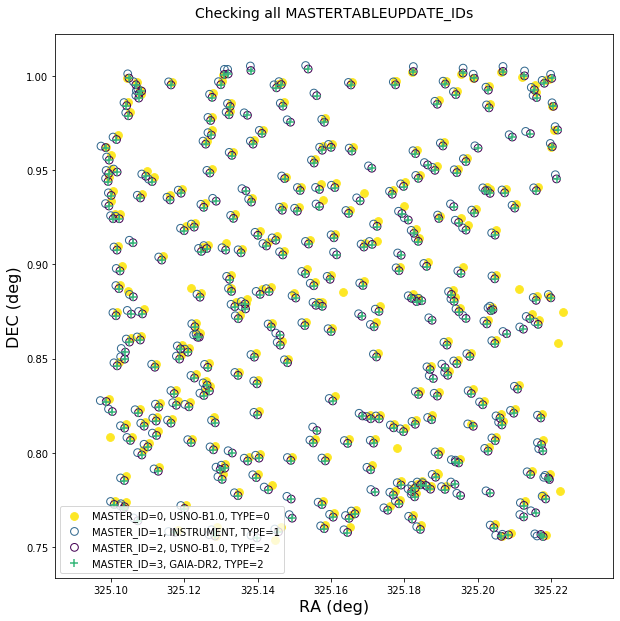

In [19]:
db_Chapter7 = db_Master = "data/MasterCatalogue_Chapter7.db"

slid_usno = 565361
slid_gaia = 76568851

MASTER_ID = [1,2]

fig, ax = plt.subplots(figsize=(10, 10), ncols=1, nrows=1)  

purple = _to_hex((0.267004, 0.004874, 0.329415))
blue_purple = _to_hex((0.267968, 0.223549, 0.512008))
blue = _to_hex((0.190631, 0.407061, 0.556089))
green_blue = _to_hex((0.128729, 0.563265, 0.551229))
green_blue2 = _to_hex((0.288921, 0.758394, 0.428426))
green = _to_hex((0.20803, 0.718701, 0.472873))
yellow_green = _to_hex((0.555484, 0.840254, 0.269281))
yellow = _to_hex((0.993248, 0.906157, 0.143936)) 

cclor = [yellow, blue, purple, green]

ra, dec = [], []

idx = 0
query = '''SELECT RA, DEC, REFCAT, MASTER_TYPE FROM MasterTable WHERE MASTERTABLEUPDATE_ID IS {}'''.format(idx)
RA_M, DEC_M, refcat, master_type = run_query(query, output='array', db_file=db_Master) 
ax.scatter(RA_M, DEC_M, marker='o', color=cclor[idx], alpha= 1, s= 60, label='MASTER_ID={}, {}, TYPE={}'.format(idx, refcat[0],master_type[0]))

ra.append(RA_M) ; dec.append(DEC_M)
    

for idx in MASTER_ID:
    query = '''SELECT RA, DEC, REFCAT, MASTER_TYPE FROM MasterTable WHERE MASTERTABLEUPDATE_ID IS {}'''.format(idx)
    RA_M, DEC_M, refcat, master_type = run_query(query, output='array', db_file=db_Master) 
    ax.scatter(RA_M, DEC_M, marker='o',facecolors='none', edgecolors=cclor[idx], alpha= 1, s= 60, label='MASTER_ID={}, {}, TYPE={}'.format(idx, refcat[0],master_type[0]))
    ra.append(RA_M) ; dec.append(DEC_M)

idx = 3
query = '''SELECT RA, DEC, REFCAT, MASTER_TYPE FROM MasterTable WHERE MASTERTABLEUPDATE_ID IS {}'''.format(idx)
RA_M, DEC_M, refcat, master_type = run_query(query, output='array', db_file=db_Master) 
# ax.scatter(RA_M, DEC_M, marker='o', facecolors='none', edgecolors=cclor[idx], alpha= 1, s= 60, label='MASTER_ID={}, TYPE={}'.format(idx, refcat[0],master_type[0]))
ax.scatter(RA_M, DEC_M, marker='+', color=cclor[idx], alpha= 1, s= 60, label='MASTER_ID={}, {}, TYPE={}'.format(idx, refcat[0],master_type[0]))

ra.append(RA_M) ; dec.append(DEC_M)
    

ax.set_title(r"Checking all MASTERTABLEUPDATE_IDs", fontsize=14, y=1.02)
ax.xaxis.set_label_text(r"RA (deg)", fontsize=16)
ax.yaxis.set_label_text(r"DEC (deg)", fontsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

fig.show()

<center><i><b>Figure 1:</b>  This figure reveals the differences in astrometry for the different types of $\texttt{AstrometricSolution}$s. 
The <font color="#fde725"> <b>yellow circles </b></font> are the USNO-B1.0 reference positions, the <font color="#31688e"> <b>blue circles</b></font> are the instumental solutions, the <font color="#440154"> <b>purple circles</b></font> are the USNO-B1.0 calibrated astrometric solutions and the <font color="#35b779"> <b>green plusses</b></font> are the Gaia calibrated astrometric solutions.
  </i></center> 

<a id = "---" REF></a>

# Additional information regarding the dataset that has been used

### Importing new astrometrical solutions

New astrometrical solutions for the `SourceList`'s with as reference catalogue Gaia DR2 obtained by the MasterCatalogue, were created in [this notebook](./__thesissectioncode__AWEPIPE_AstromCal_SCAMP__.ipynb). The information regarding the SLIDS, its `ReducedScienceFrame` and the creation date of the `AstrometricParameters` can be found below. 

| SLID | `ReducedScienceFrame.filename` | creation_date |
|:------|:------|:-------|
|76154181 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4509118-d4b707aaab715eea0e4f31d755a17cae52ea6fe6.fits | 2020-07-15 11:07:15.672871 |
|76154971 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4488546-e091486df8b9b90a30317fea6474ff13ac872385.fits | 2020-07-15 11:07:27.800698 |
|76154981 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4497613-be85c0271a730a2ba1364e119e5a8cd39d2fec28.fits | 2020-07-15 11:07:41.184674 |
|76154991 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4561888-fe585b1c45c911967f21b7291c6b387bf6885aea.fits | 2020-07-15 11:07:53.397970 |
|76155001 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4844704-85f3df9694c81cdbb2ce2aa79835a8841c75ba8d.fits | 2020-07-15 11:08:06.126560 |
|76155011 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.5188061-991426e55bfc3d88be7f892404cf5297861531fc.fits | 2020-07-15 11:08:18.752287 |
|76155021 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.3075176-e2aa902ff2918158aeb0cc554b984eebb931a88a.fits | 2020-07-15 11:08:31.397719 |
|76155031 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.3081612-ac2aee49f284899f7ee483649bd0735df6f83324.fits | 2020-07-15 11:08:41.424390 |
|76155041 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.3899330-d1b3ab02d8739df33f6f8d97ca20a06958ae970b.fits | 2020-07-15 11:08:52.734014 |
|76155051 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.2861694-4b8efb28023197172487ba2cb6b8a29d67011a3e.fits | 2020-07-15 11:09:02.831896 |
|76155061 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.4806177-34c3c97e5d35c82f6ce0262c776e1d5c4ef864f5.fits | 2020-07-15 11:09:15.505703 |
|76155071 |Sci-WMULDER-OMEGACAM-------OCAM_r_SDSS-ESO_CCD_#90-Red---Sci-58969.6106413-ebcfe48156cdb23909d31fb9df7d26a814f9965b.fits | 2020-07-15 11:09:29.177374 |
```